## Подготовка данных для модели

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../data/raw/train.csv")

In [3]:
X = df.drop(columns=['Id', 'Alley', 'PoolQC', 'MiscFeature', 'SalePrice'])
y = df['SalePrice']

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [5]:
from src.data.preprocessing import DataPreprocessor, TargetTransformer, FeatureSelector

selector = FeatureSelector().fit(X_train)

preprocessor = DataPreprocessor()
column_transformer = preprocessor.build(
    numeric_features=selector.numeric_features,
    categorical_features=selector.categorical_features
)

## Baseline модель

Сначала попробуем сделать baseline с линейной моделью с L2 регуляризацией и посмотрим на метрики. Затем также попробуем градиентный бустинг (LightGBM)

### Ridge baseline

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor

pipeline = Pipeline(
    steps=[
        ("preprocessing", column_transformer),
        ("model", Ridge())
    ]
)

baseline_model = TransformedTargetRegressor(
    regressor=pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

In [7]:
from sklearn.metrics import root_mean_squared_log_error

baseline_model.fit(X_train, y_train)
y_pred_train = baseline_model.predict(X_train)
y_pred_val = baseline_model.predict(X_val)
print("baseline RMSE on train: %.5f" % root_mean_squared_log_error(y_train, y_pred_train))
print("baseline RMSE on val: %.5f" % root_mean_squared_log_error(y_val, y_pred_val))

baseline RMSE on train: 0.09970
baseline RMSE on val: 0.12805


In [8]:
submission = pd.read_csv("../data/raw/sample_submission.csv")
df_test = pd.read_csv("../data/raw/test.csv")

X_test = df_test.drop(columns=['Id', 'Alley', 'PoolQC', 'MiscFeature'])

y_pred_test = baseline_model.predict(X_test)
submission['SalePrice'] = y_pred_test
submission.to_csv("../data/output/my_submission.csv")

### LightGBM baseline

In [9]:
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import root_mean_squared_log_error

In [10]:
def train_and_val_baseline(data, features_to_drop, target, baseline=LGBMRegressor()):
    X = data.drop(columns=features_to_drop + [target])
    y = data[target]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    selector = FeatureSelector().fit(X_train)
    preprocessor = DataPreprocessor()
    column_transformer = preprocessor.build(
        numeric_features=selector.numeric_features,
        categorical_features=selector.categorical_features
    )
    
    pipeline = Pipeline(
        steps=[
            ("preprocessing", column_transformer),
            ("model", baseline)
        ]
    )
    
    baseline_model = TransformedTargetRegressor(
        regressor=pipeline,
        func=np.log1p,
        inverse_func=np.expm1
    )

    baseline_model.fit(X_train, y_train)
    y_pred_train = baseline_model.predict(X_train)
    y_pred_val = baseline_model.predict(X_val)
    print("baseline RMSE on train: %.5f" % root_mean_squared_log_error(y_train, y_pred_train))
    print("baseline RMSE on val: %.5f" % root_mean_squared_log_error(y_val, y_pred_val))

    return baseline_model

In [11]:
features_to_drop = ['Id', 'Alley', 'PoolQC', 'MiscFeature']
fitted_model = train_and_val_baseline(df, features_to_drop, 'SalePrice')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3200
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 176
[LightGBM] [Info] Start training from score 12.030658
baseline RMSE on train: 0.04227
baseline RMSE on val: 0.14054


D:\MyScripts\SDS\.venv\NASDAQ-risk-return-analisys\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
D:\MyScripts\SDS\.venv\NASDAQ-risk-return-analisys\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [12]:
submission = pd.read_csv("../data/raw/sample_submission.csv")
df_test = pd.read_csv("../data/raw/test.csv")

X_test = df_test.drop(columns=features_to_drop)

y_pred_test = fitted_model.predict(X_test)
submission['SalePrice'] = y_pred_test
submission.to_csv("../data/output/my_submission.csv", index=False)

D:\MyScripts\SDS\.venv\NASDAQ-risk-return-analisys\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


В качестве базовых моделей были рассмотрены две модели: линейная регрессия Ridge и модель на основе деревьев — LightGBM.

Ridge-регрессия показала немного лучшее качество на локальной валидационной выборке (0.14054 у LightGBM и 0.12805 у Ridge), что ожидаемо ввиду её простоты и меньшей дисперсии.

В то же время LightGBM продемонстрировала сопоставимое качество на валидации и немного лучшие результаты на публичном тесте Kaggle (0.14015 у LightGBM и 0.14286 у Ridge). Учитывая способность данной модели улавливать нелинейные зависимости и взаимодействия между признаками, LightGBM была выбрана в качестве основной baseline-модели для дальнейших экспериментов.

Кроме того, бустинговые модели на основе деревьев предоставляют большую гибкость для feature engineering и подбора гиперпараметров, что делает их подходящим выбором для итеративного улучшения модели.

## Feature engineering

Сначала выведем матрицу корреляции для численных признаков и violin plots для категориальных, чтобы понять их взаимосвязь между собой/их связь с таргетом

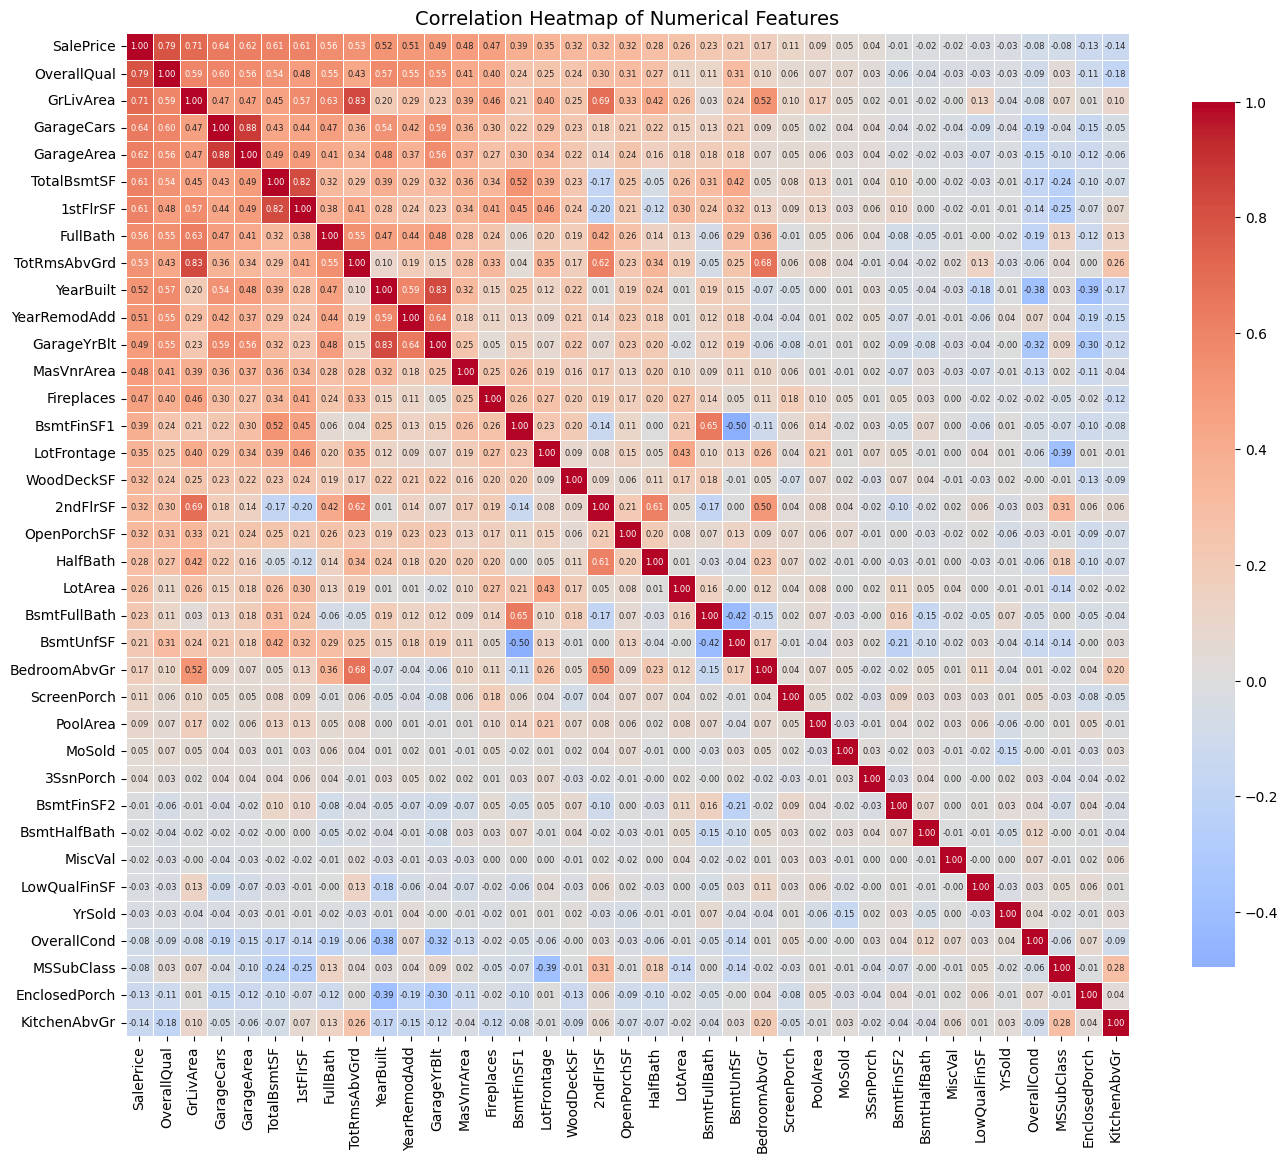

In [13]:
target = 'SalePrice'
num_cols = selector.numeric_features

num_df = df[num_cols + [target]]
corr_matrix = num_df.corr()

# Отсортируем признаки по корреляции с таргетом
corr_with_target = corr_matrix[target].sort_values(ascending=False)
sorted_cols = corr_with_target.index
corr_matrix = corr_matrix.loc[sorted_cols, sorted_cols]

# Рисуем тепловую карту
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot=True,
    fmt=".2f",
    annot_kws={"size": 6}

)

plt.title('Correlation Heatmap of Numerical Features', fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
selector.categorical_features

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'Fence',
 'SaleType',
 'SaleCondition']

In [15]:
len(selector.categorical_features)

40

<Axes: xlabel='Street', ylabel='SalePrice'>

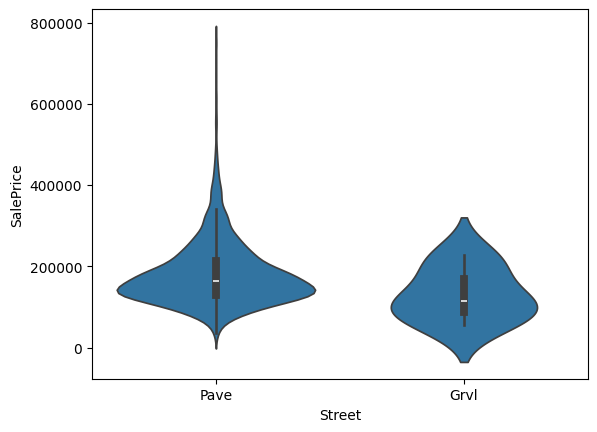

In [16]:
sns.violinplot(data=df, x='Street', y='SalePrice')

In [17]:
df.Street.value_counts()

Street
Pave    1454
Grvl       6
Name: count, dtype: int64

Получаем, что признак Street практически неинформативен, т.к. почти все объекты выборки имеют значение признака Street='Pave' и средняя цена домов практически не меняется в зависимости от типа дороги, ведущей к ним. Значит этот признак можно просто убрать из датасета.

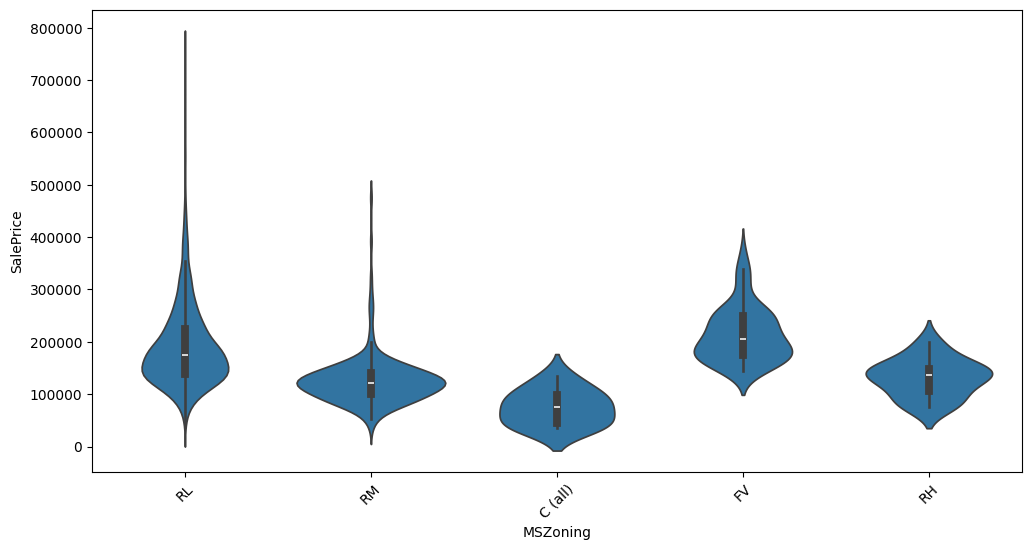

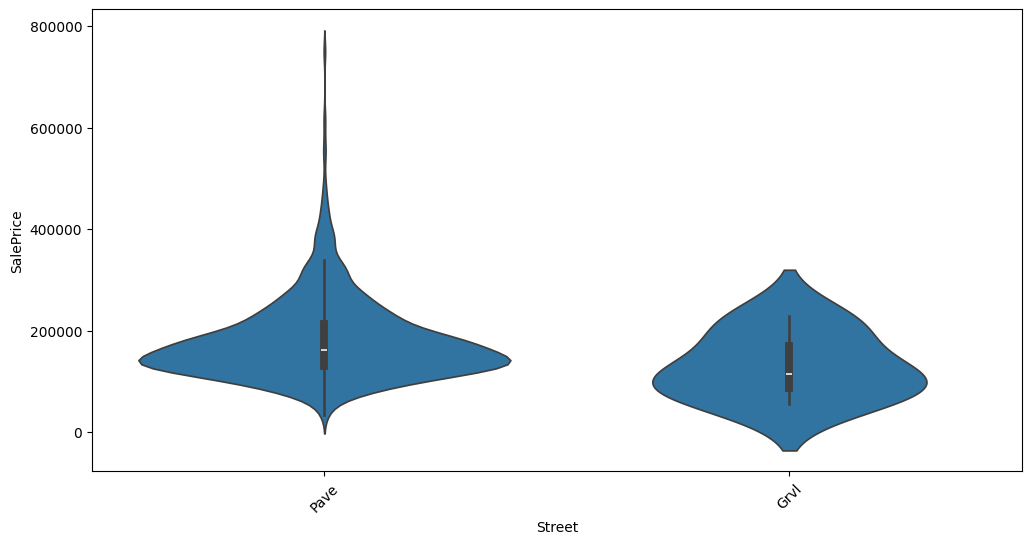

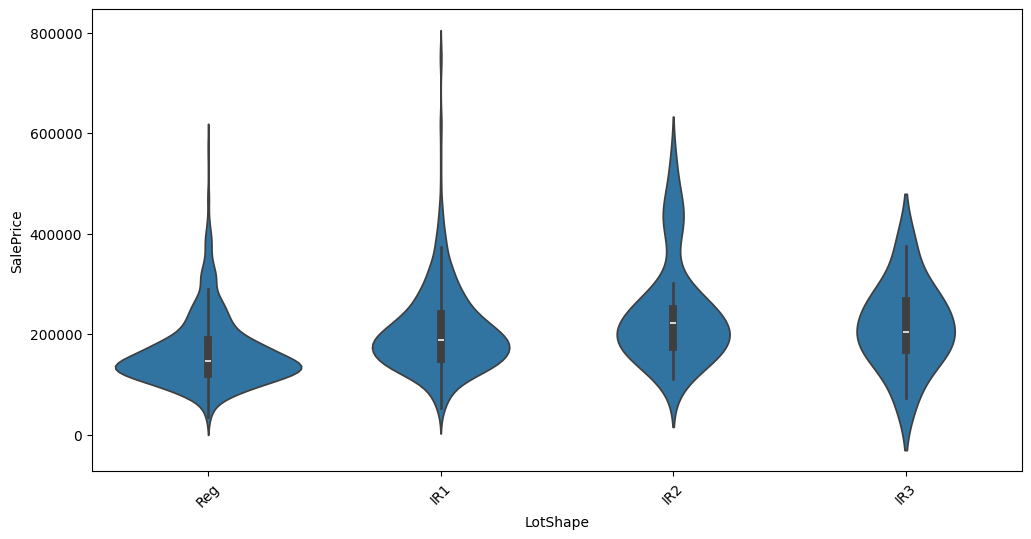

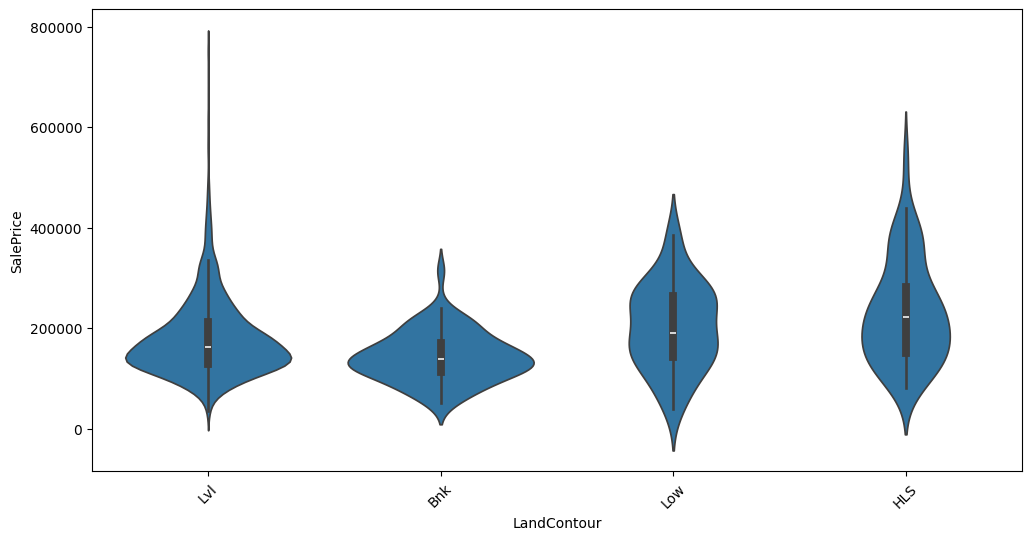

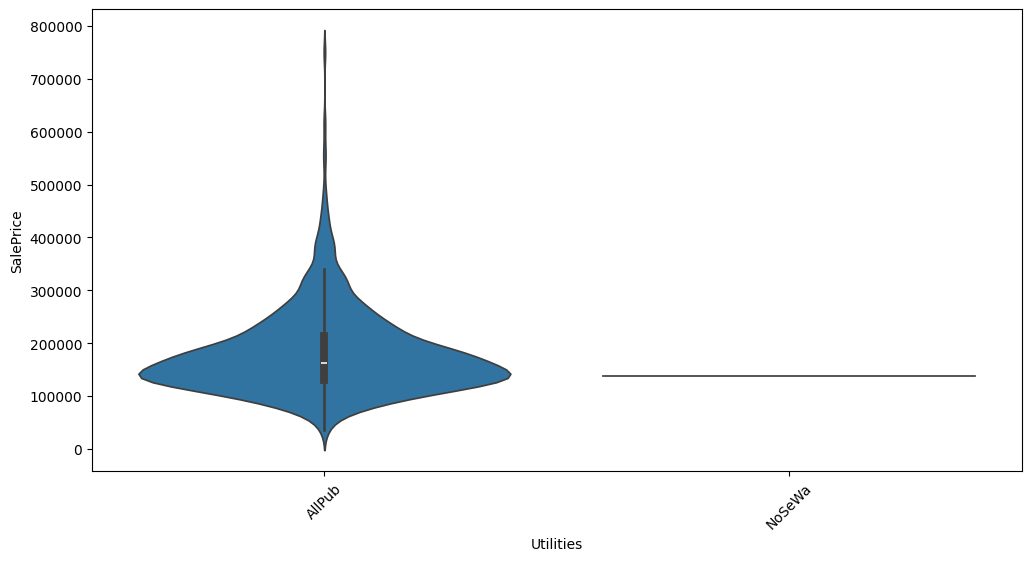

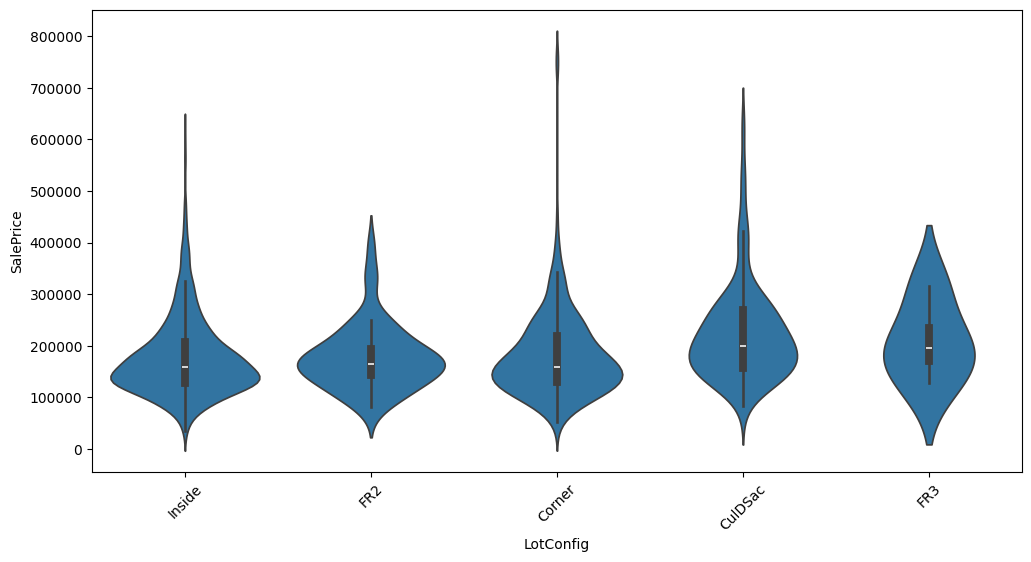

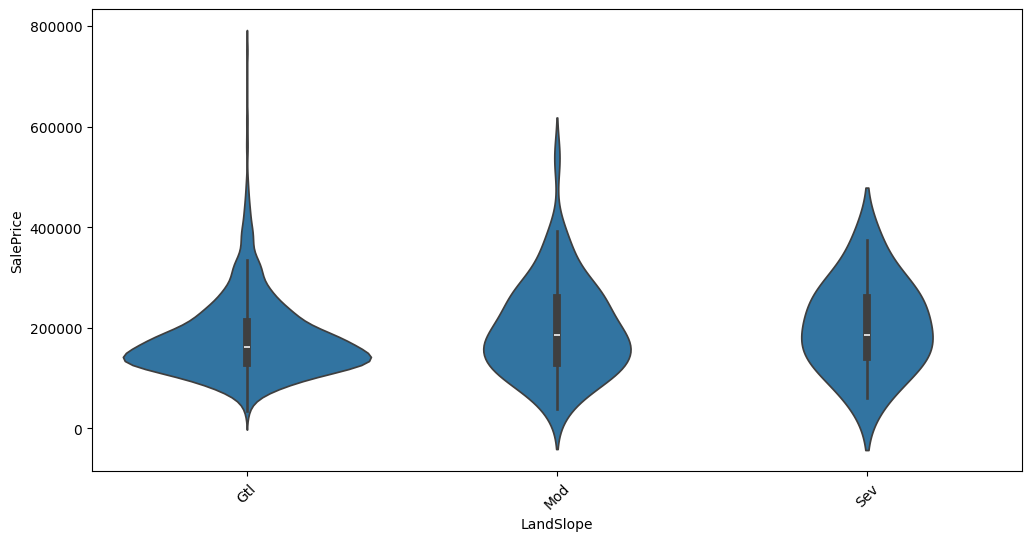

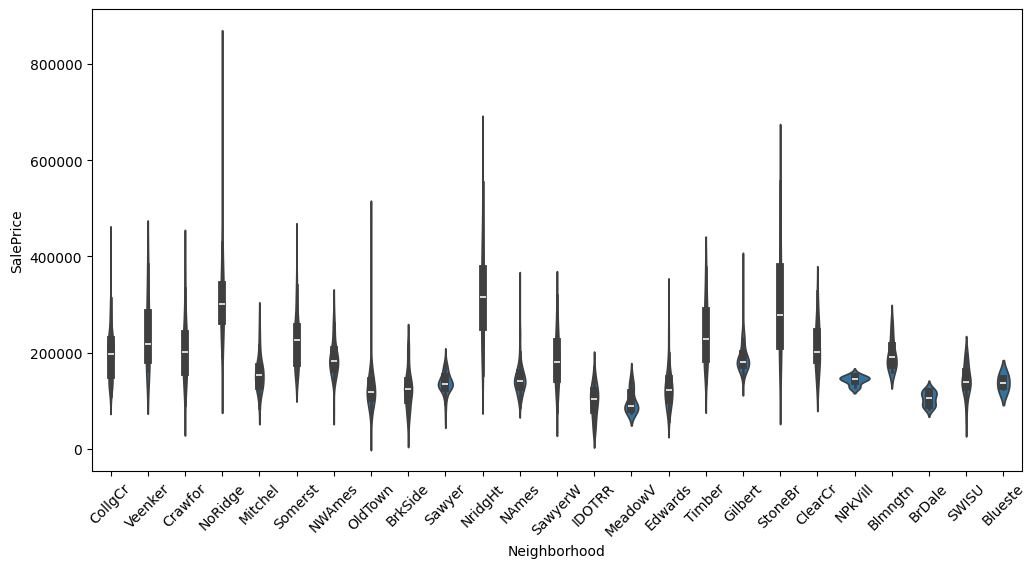

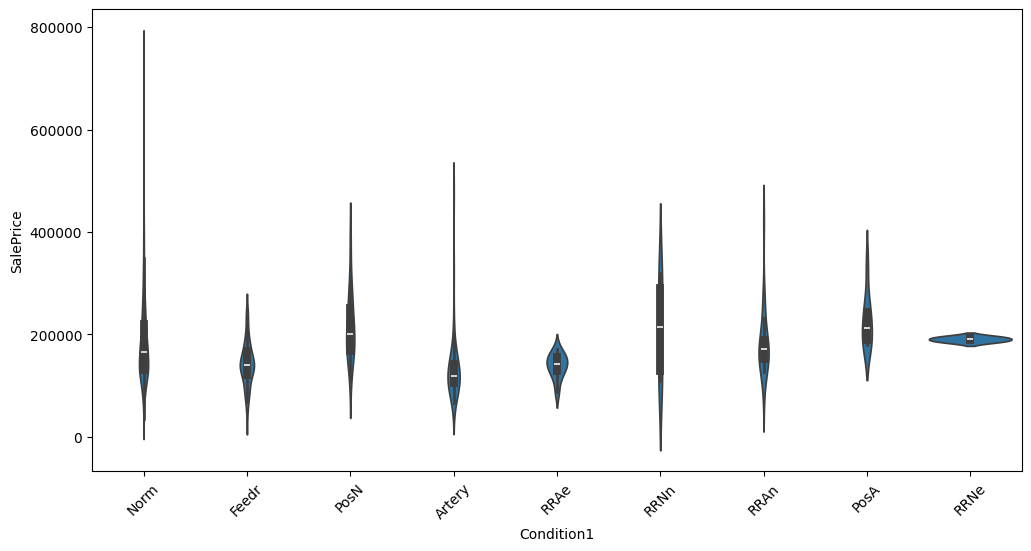

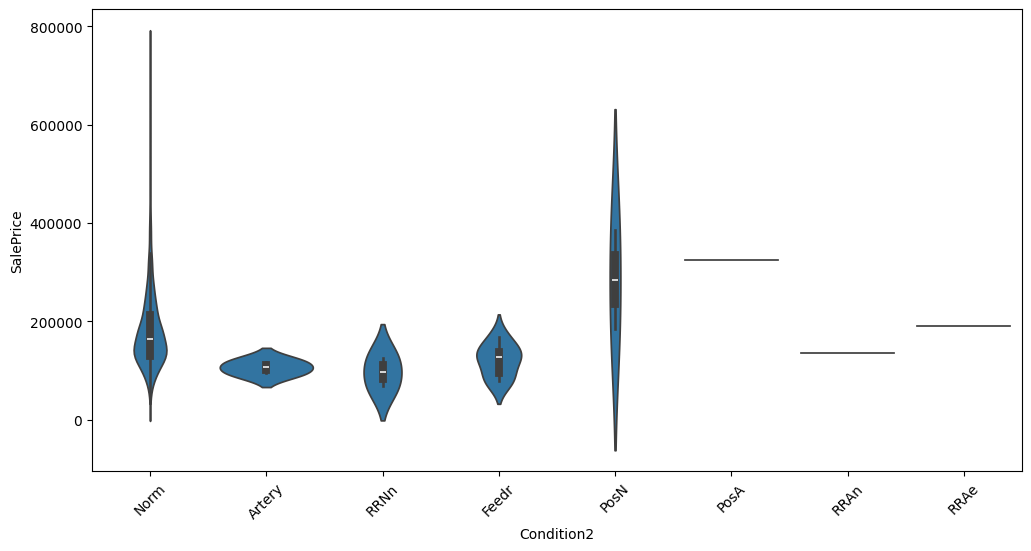

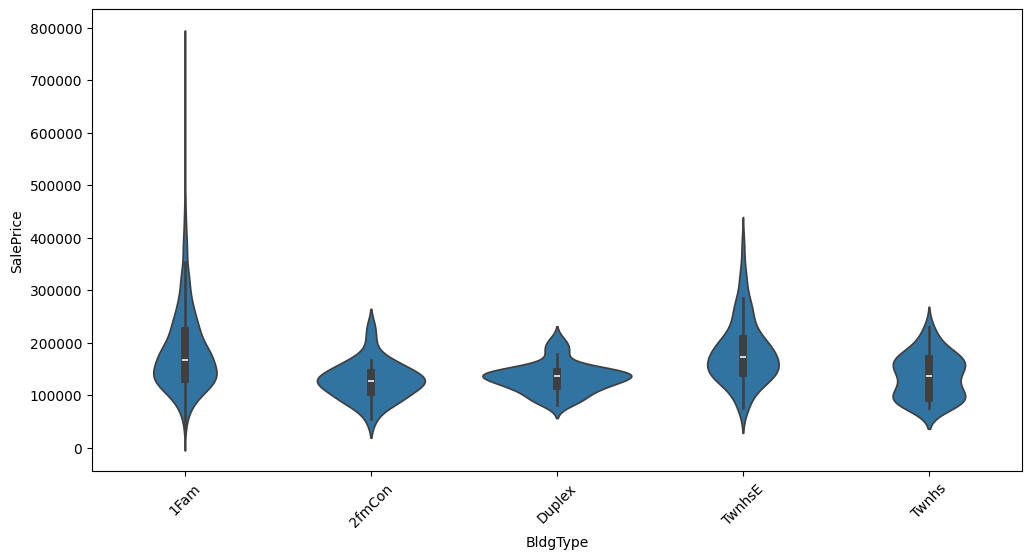

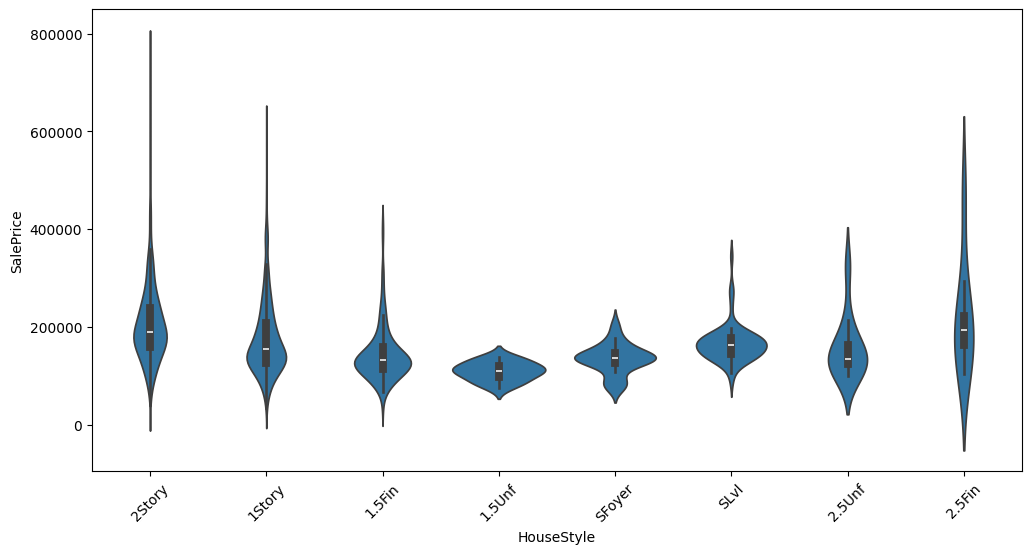

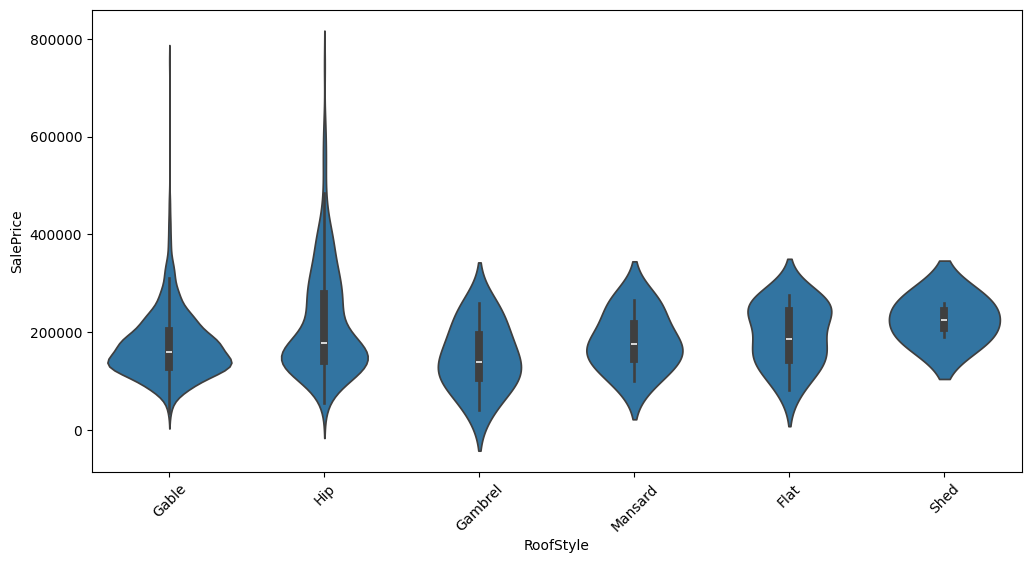

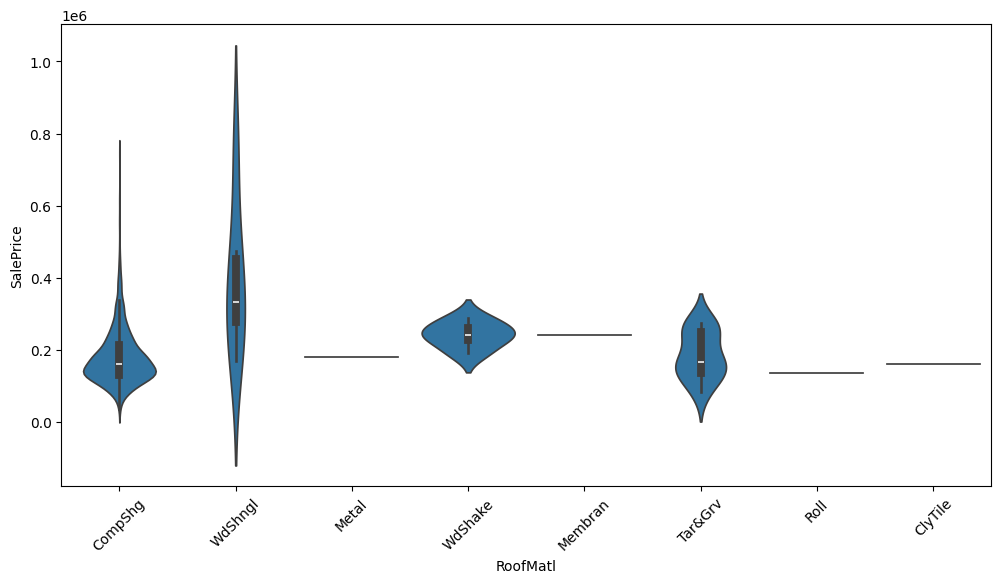

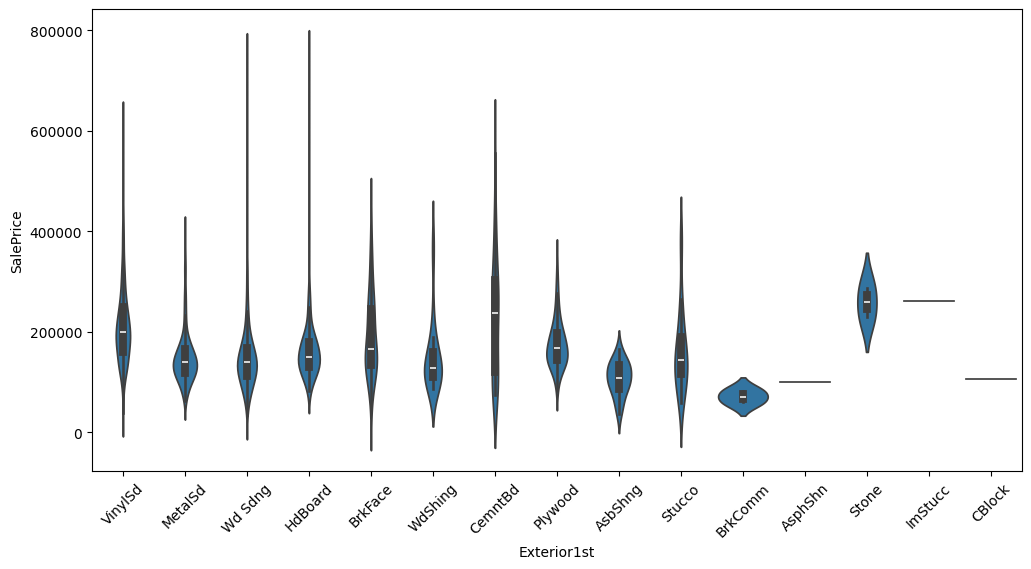

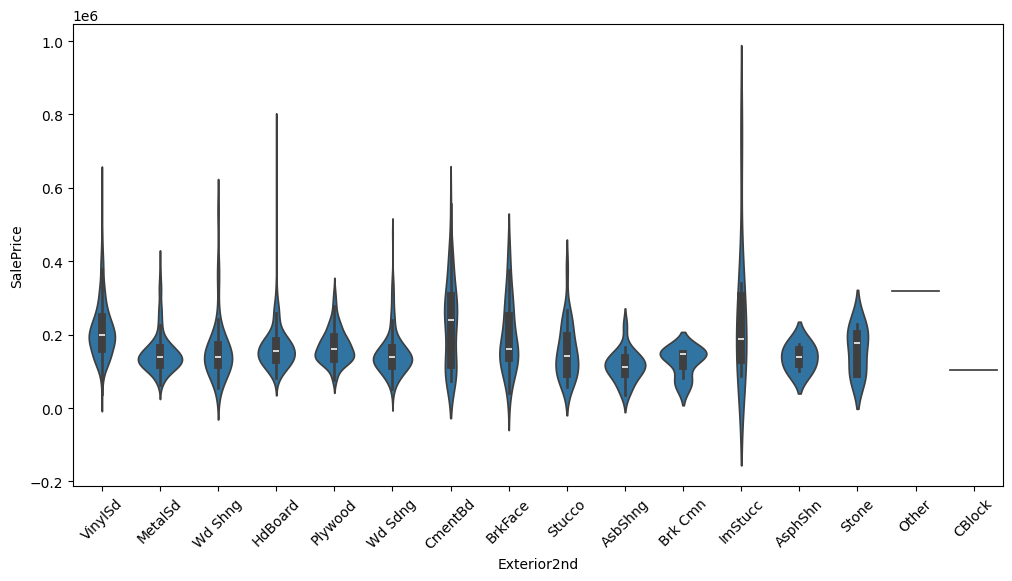

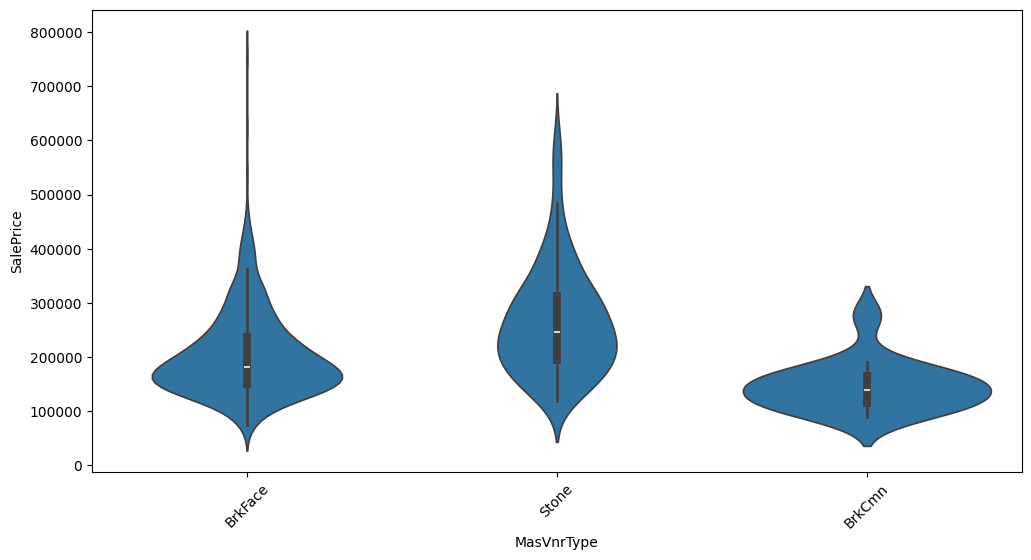

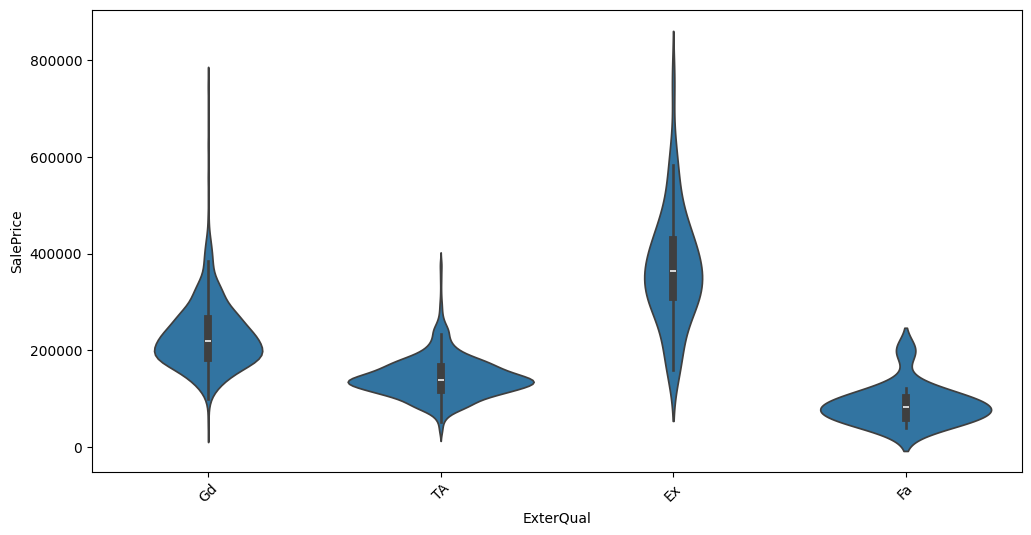

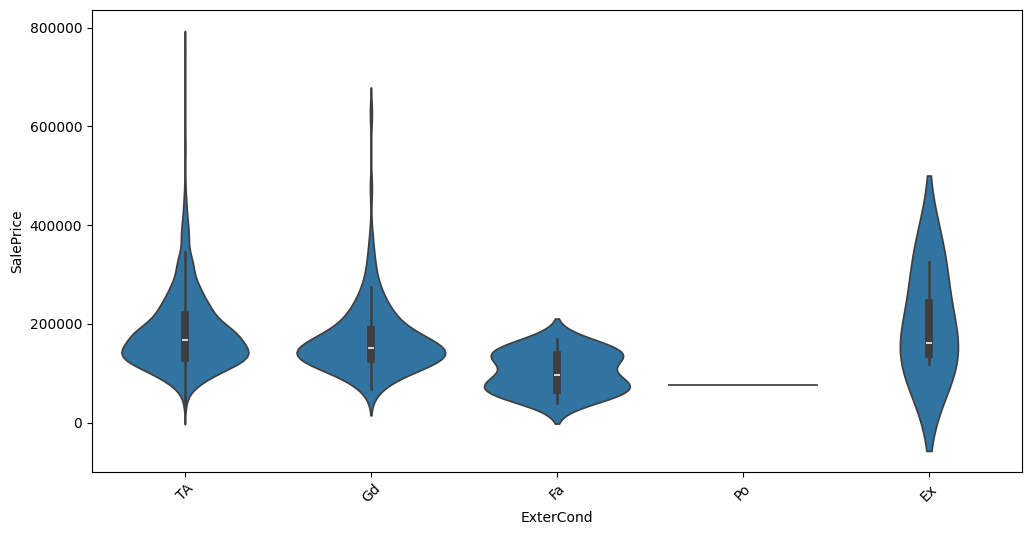

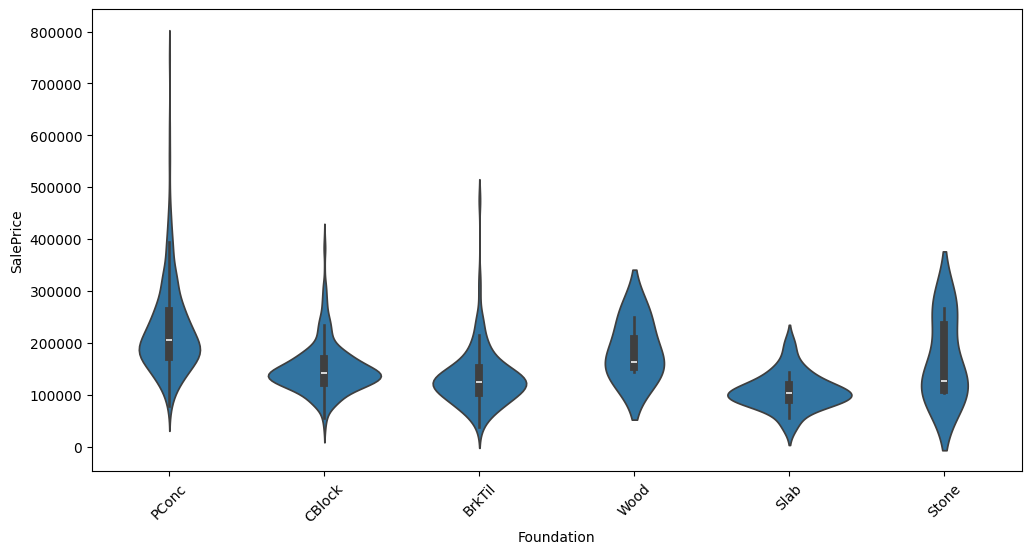

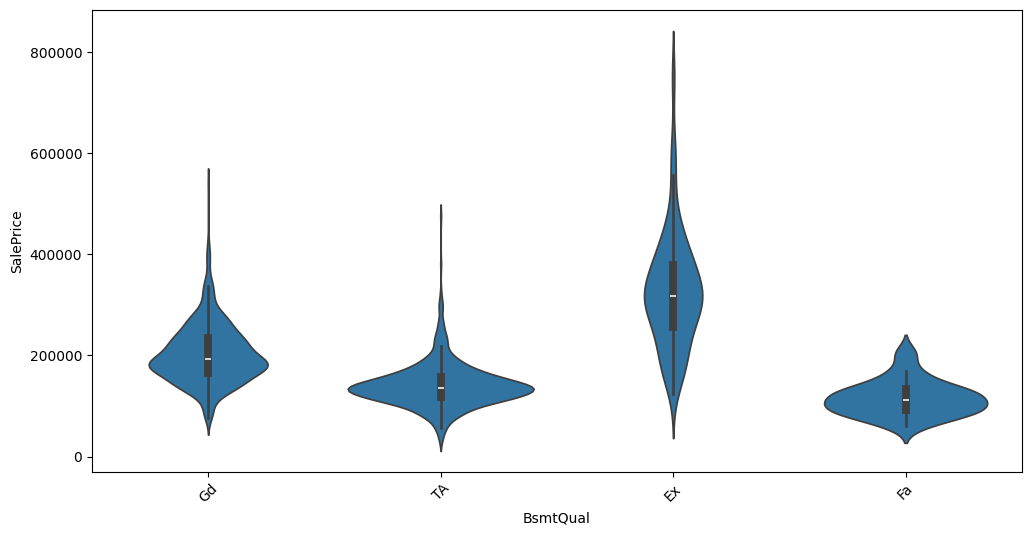

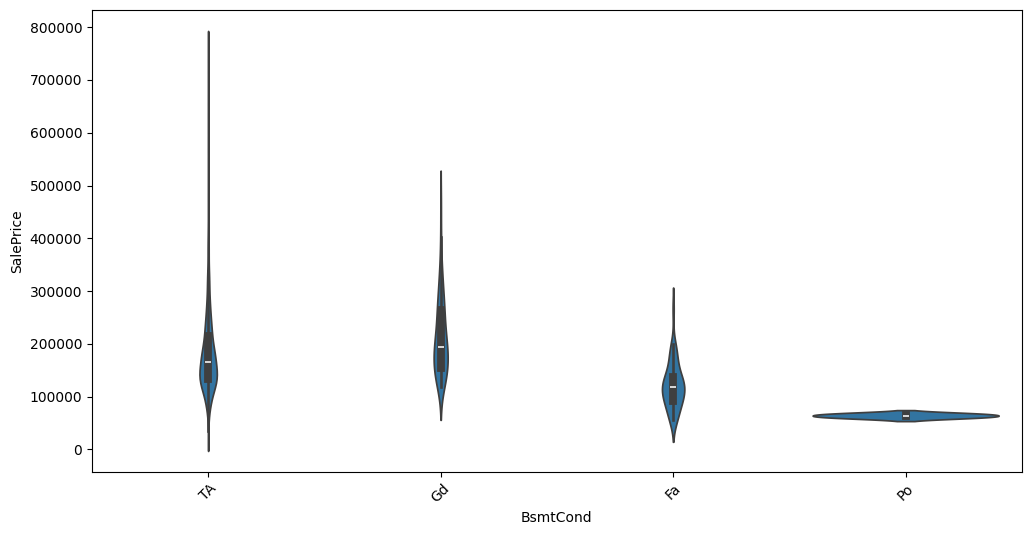

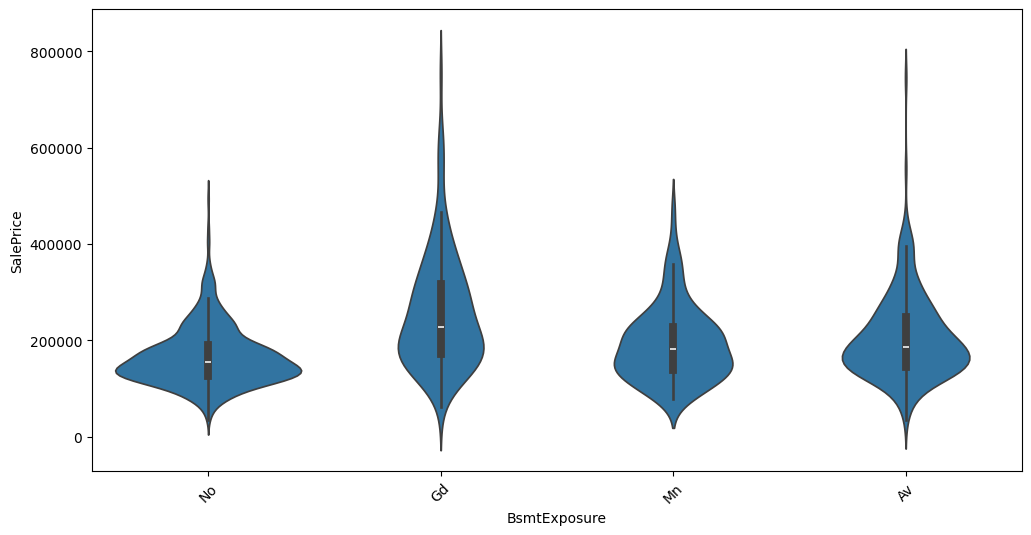

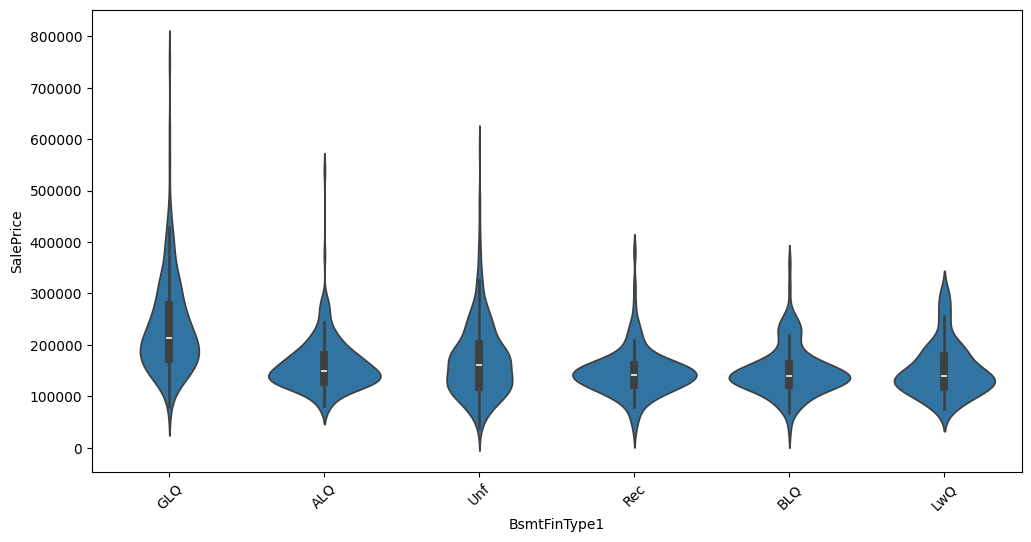

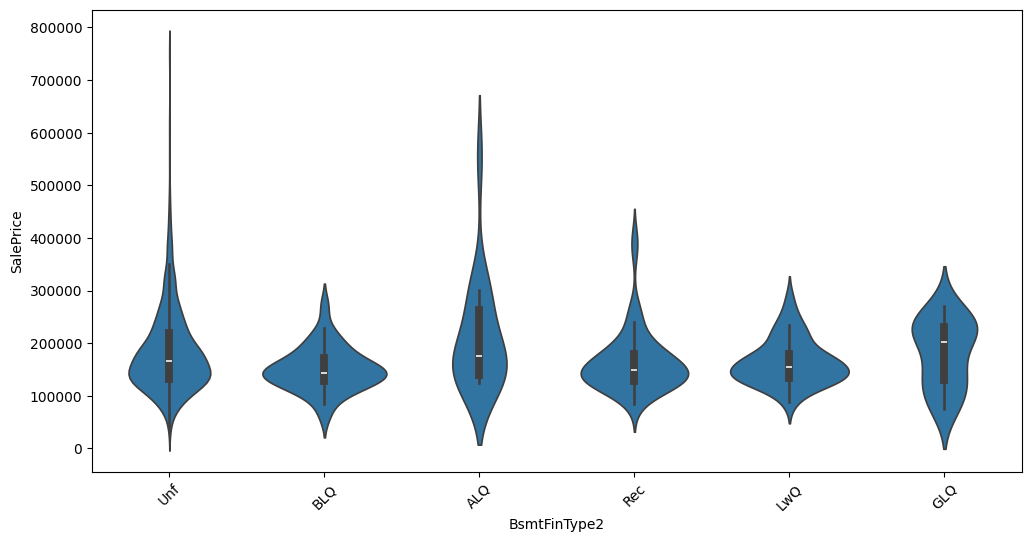

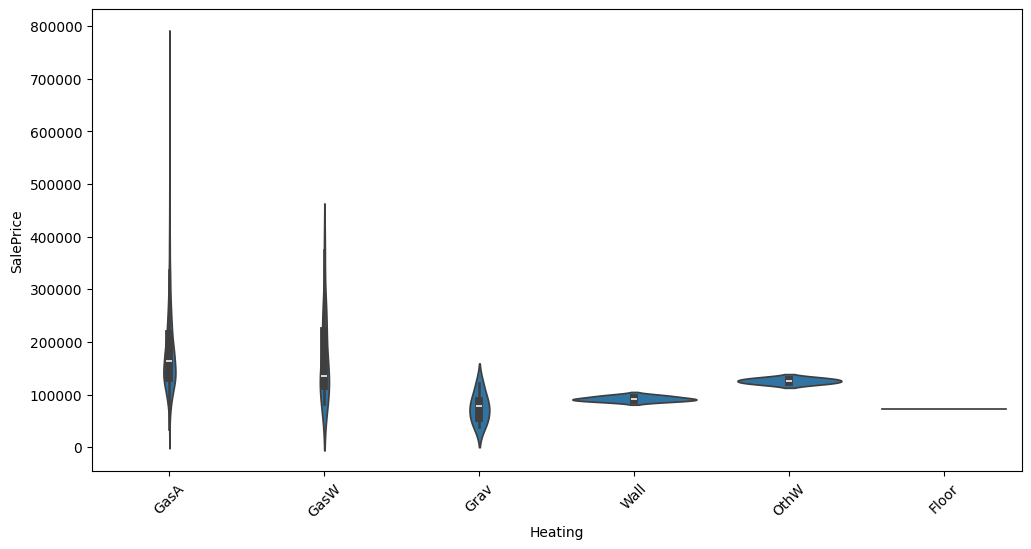

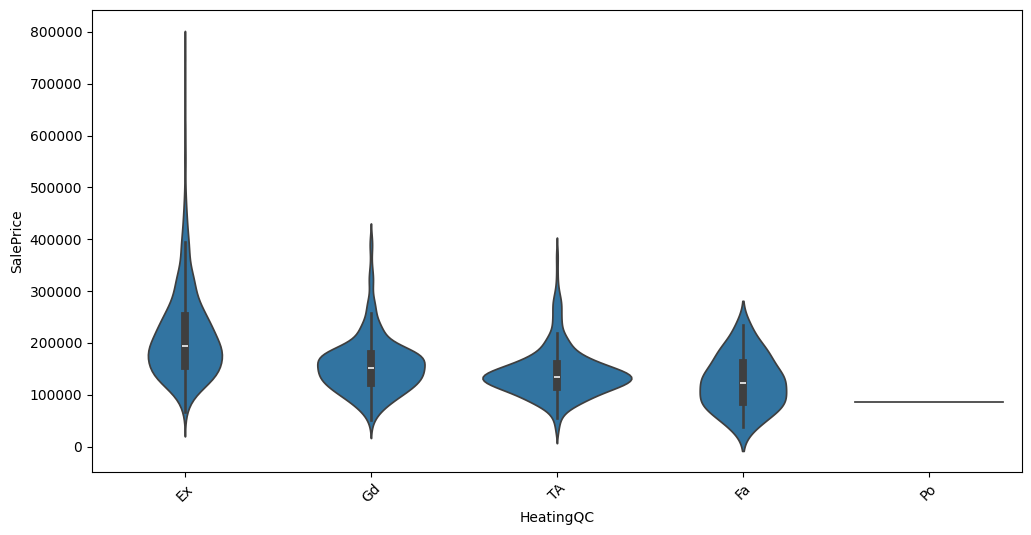

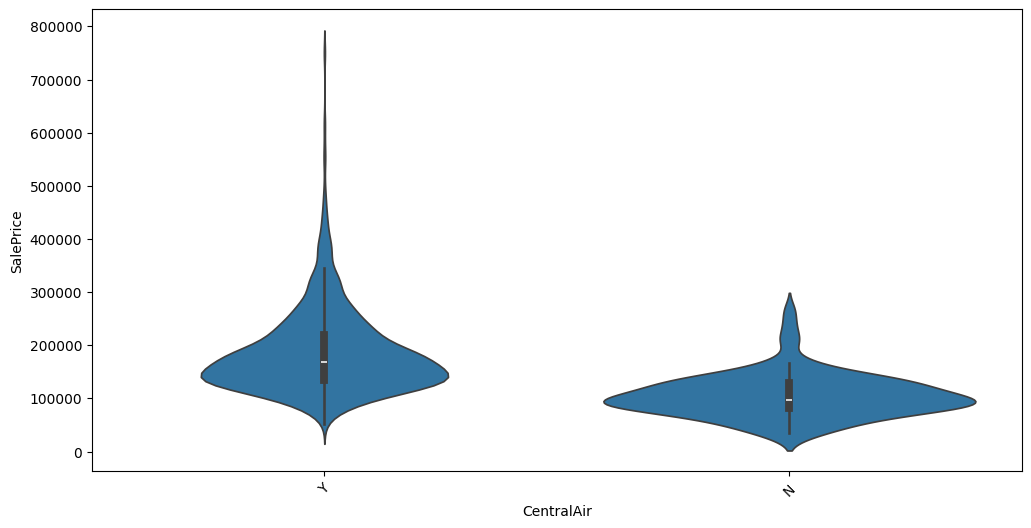

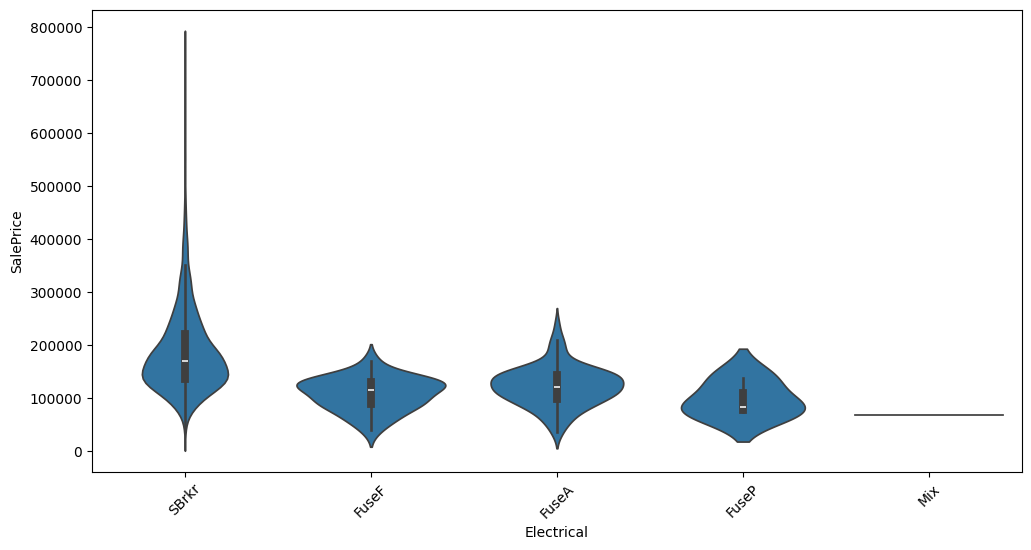

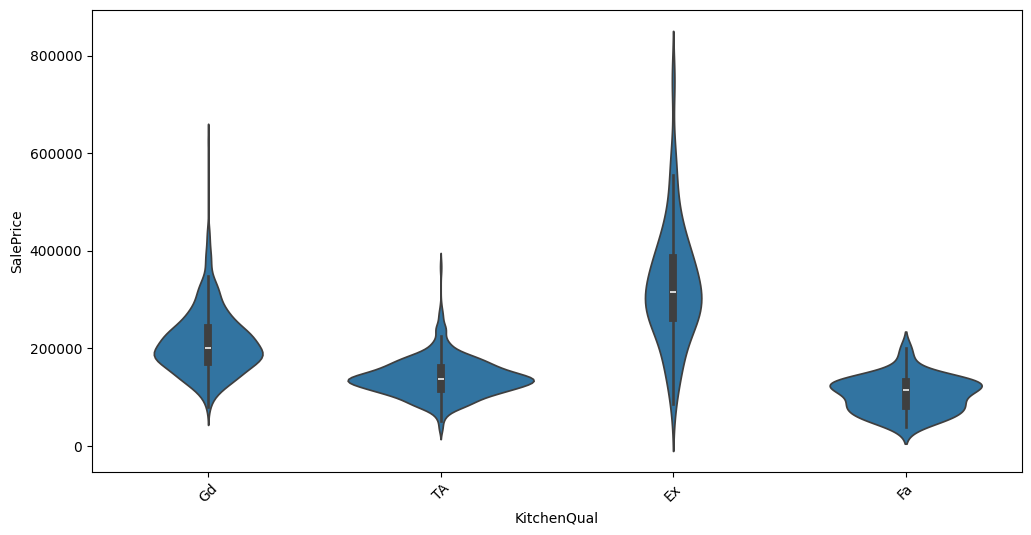

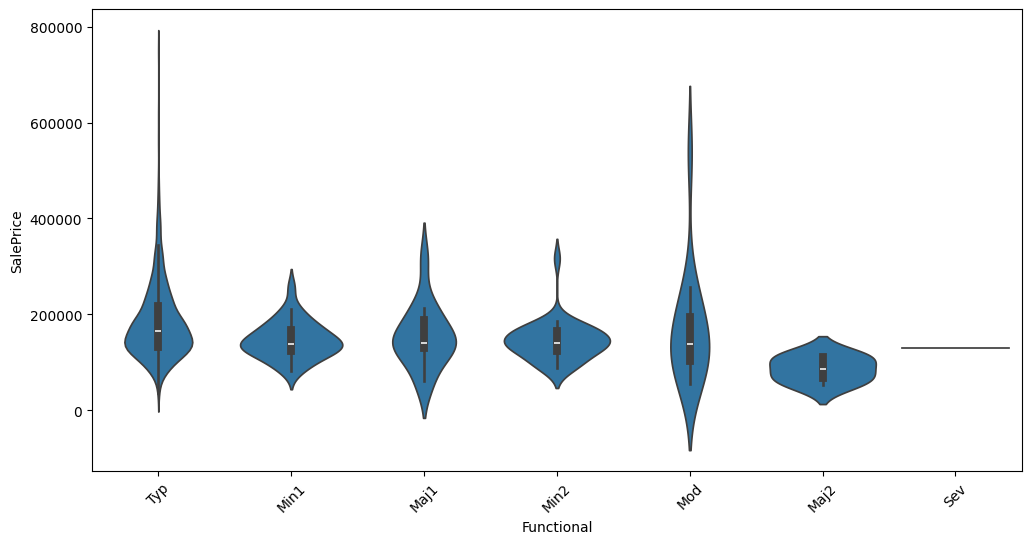

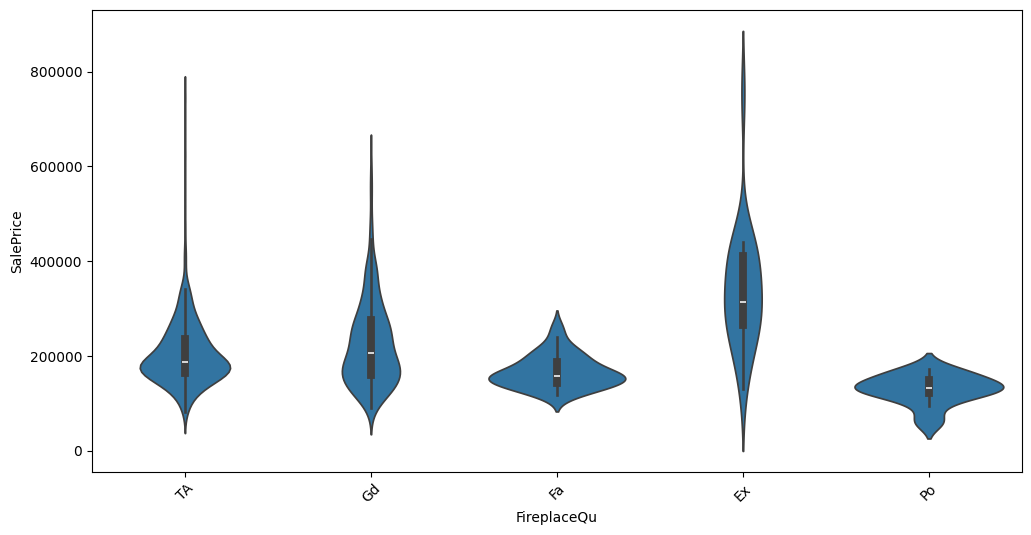

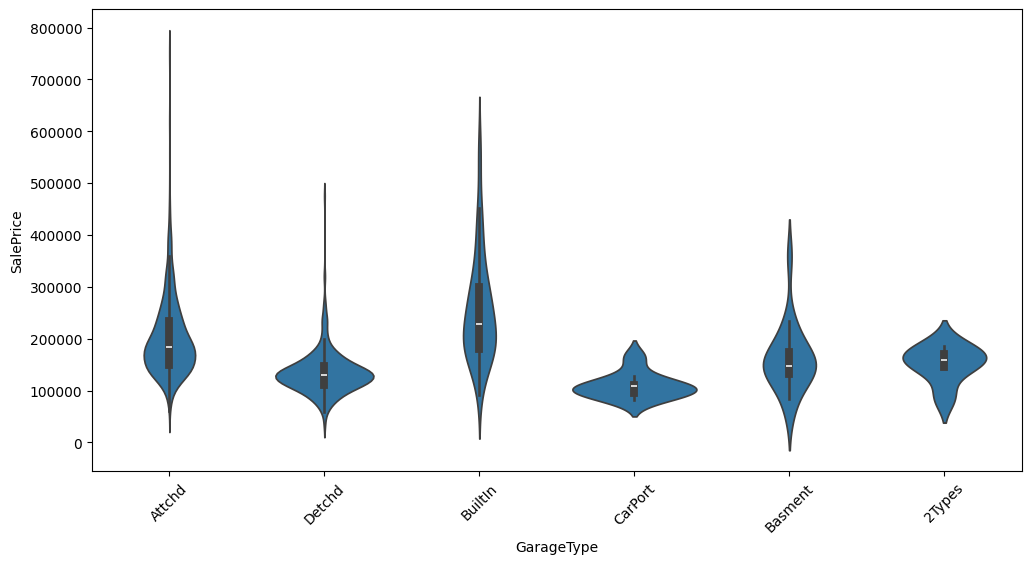

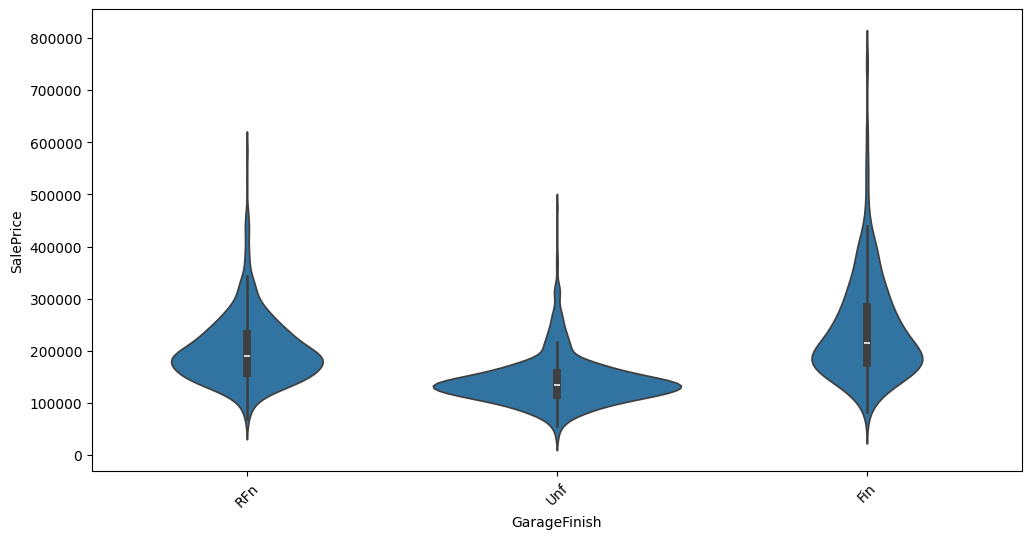

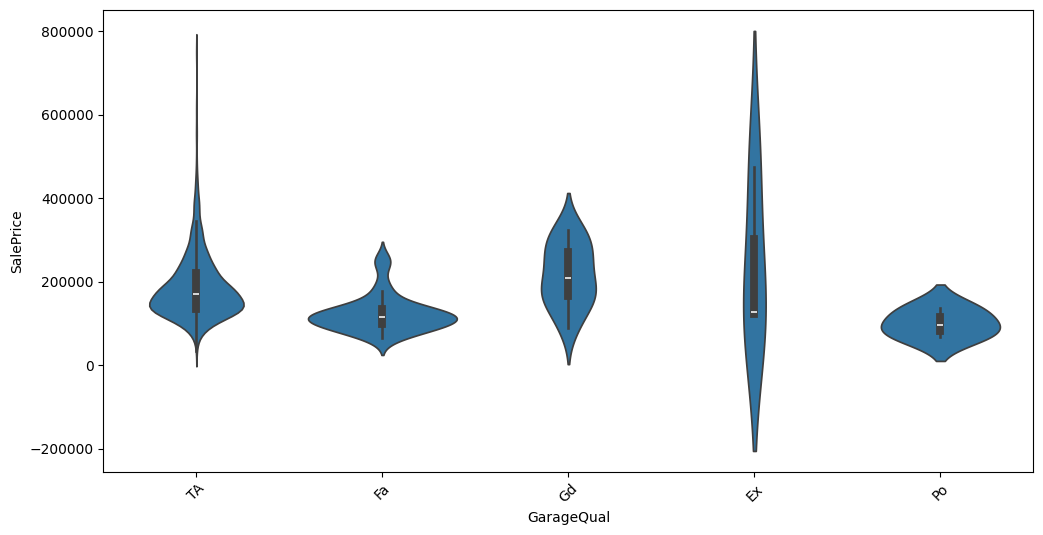

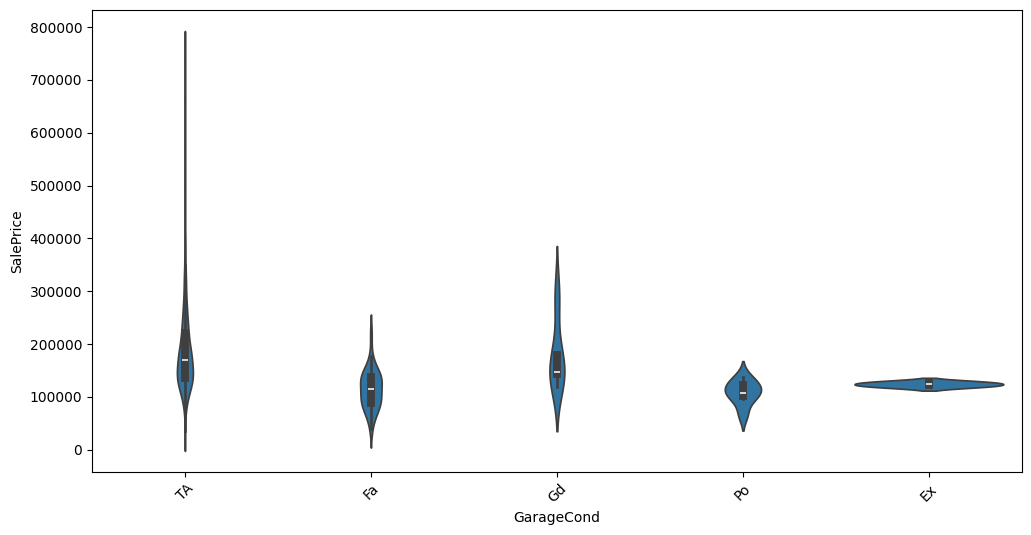

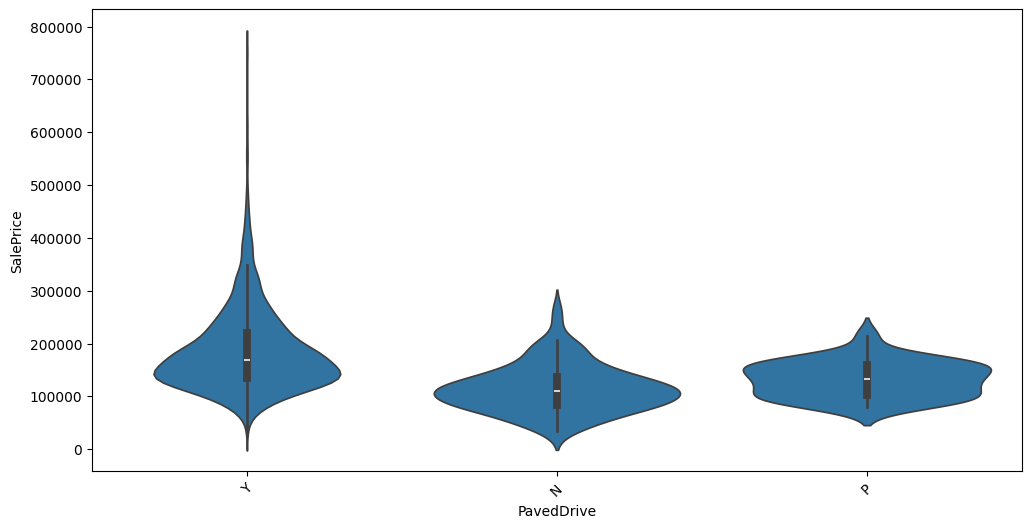

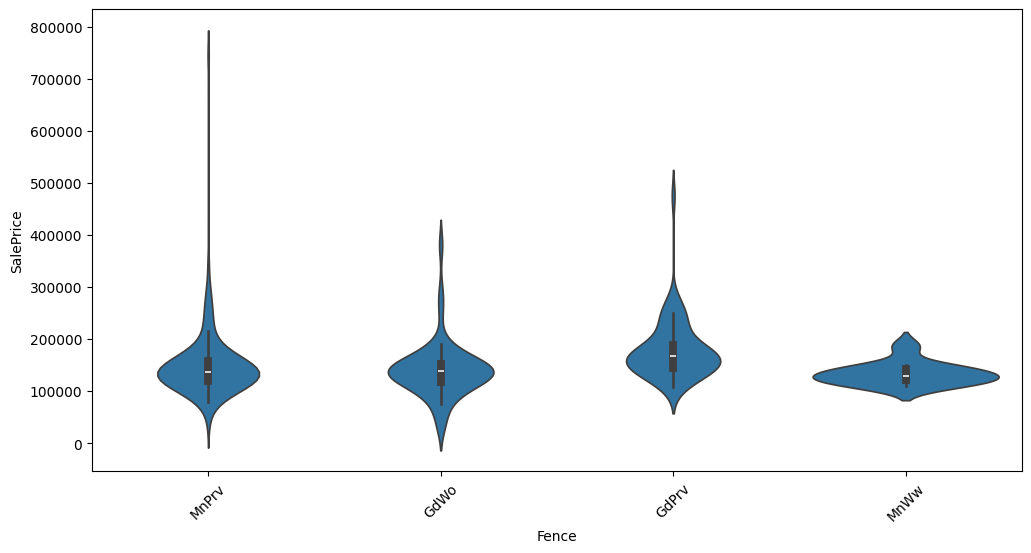

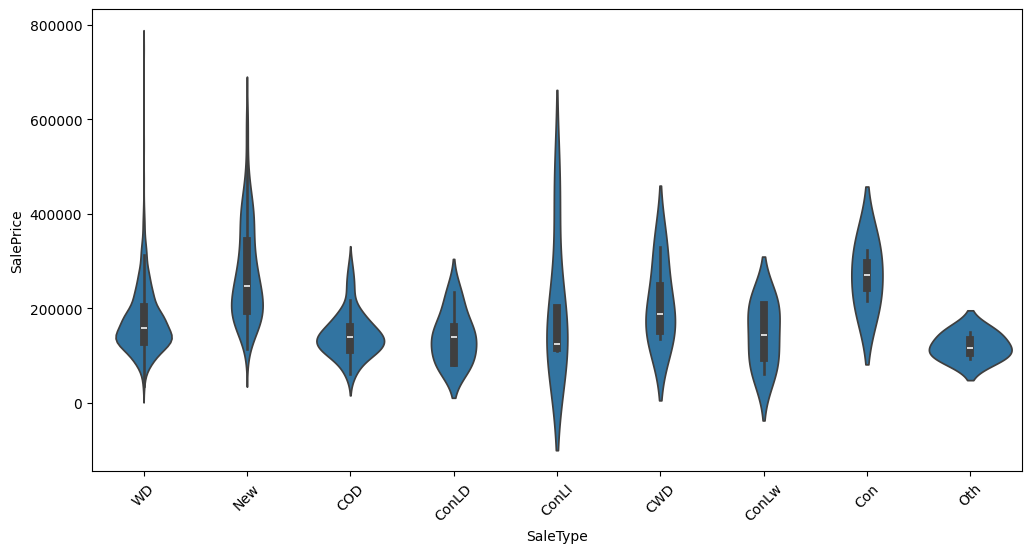

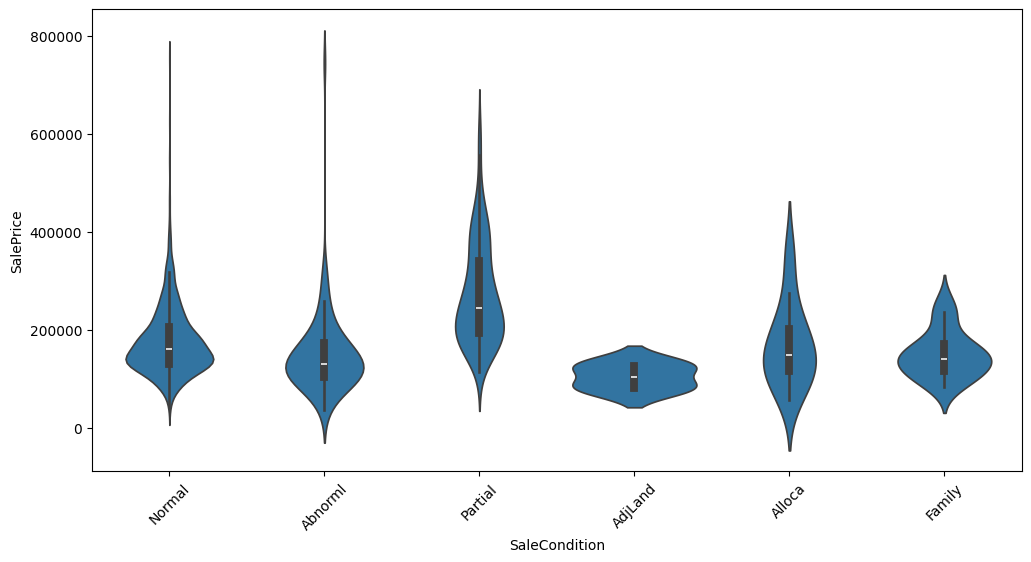

In [18]:
for feature_name in selector.categorical_features:
    plt.figure(figsize=(12,6))
    sns.violinplot(x=feature_name, y='SalePrice', data=df)
    plt.xticks(rotation=45)
    plt.show()

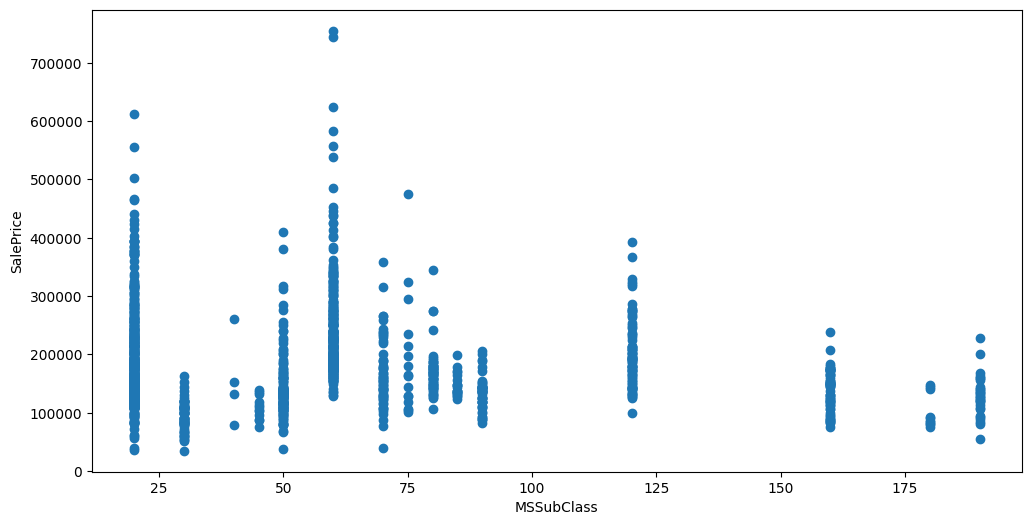

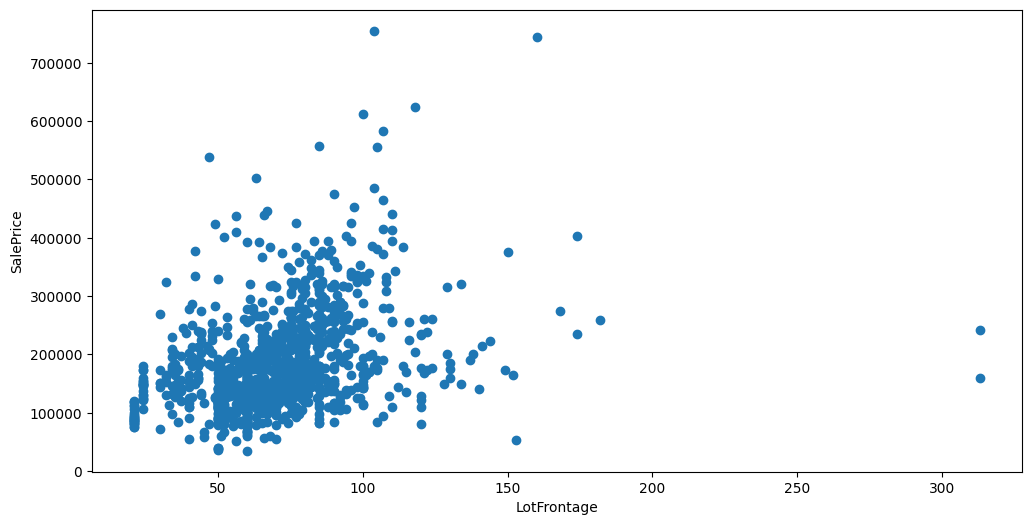

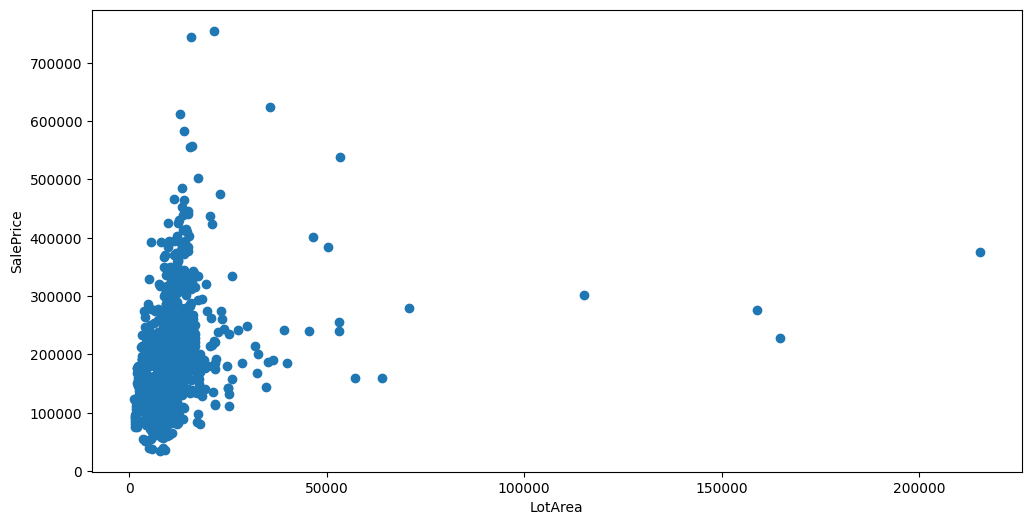

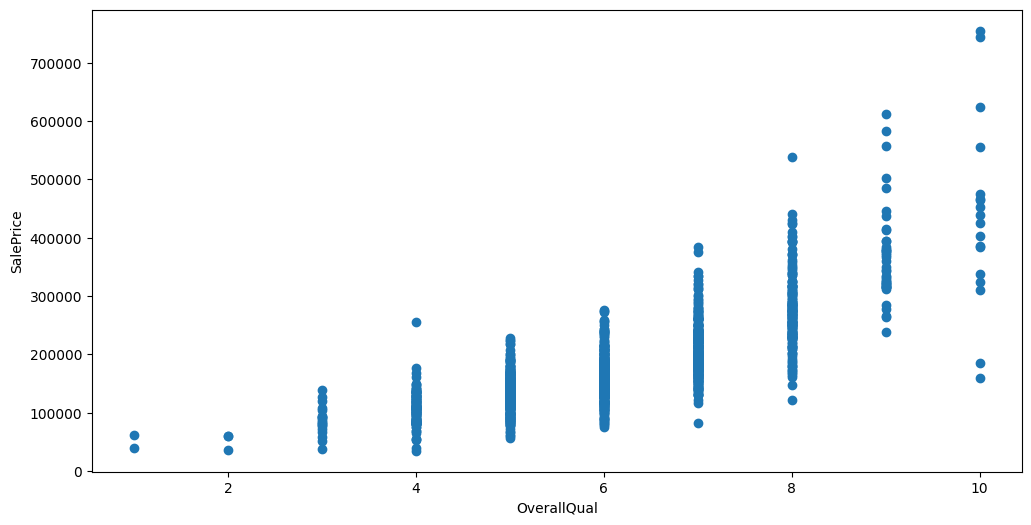

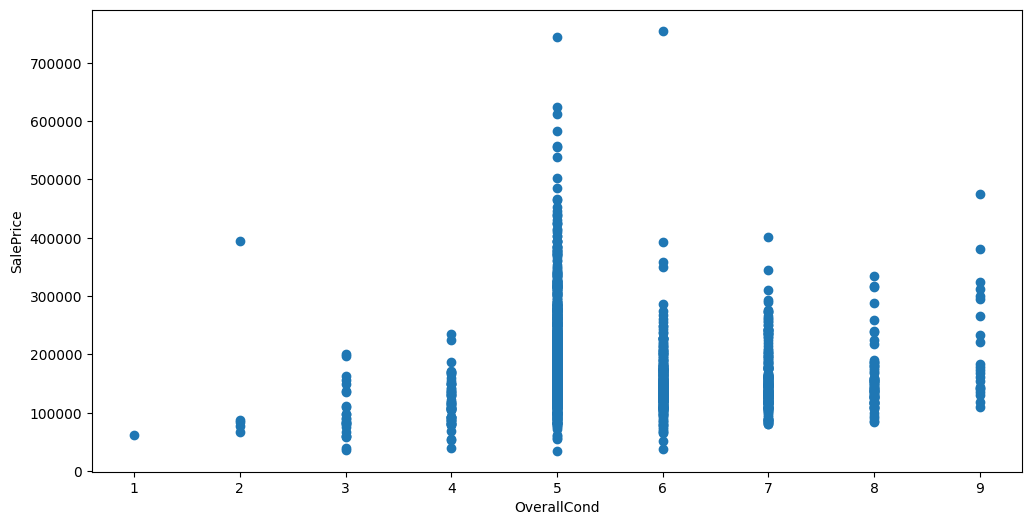

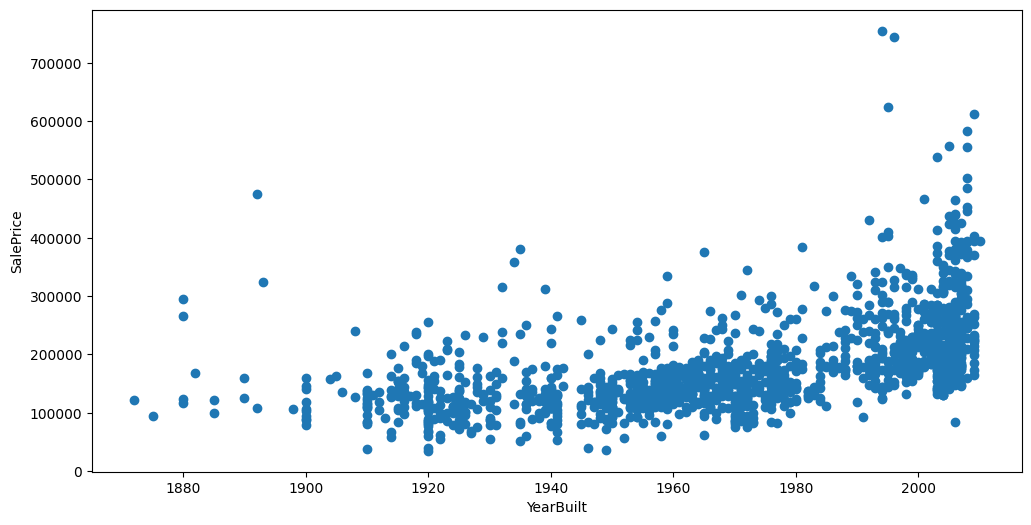

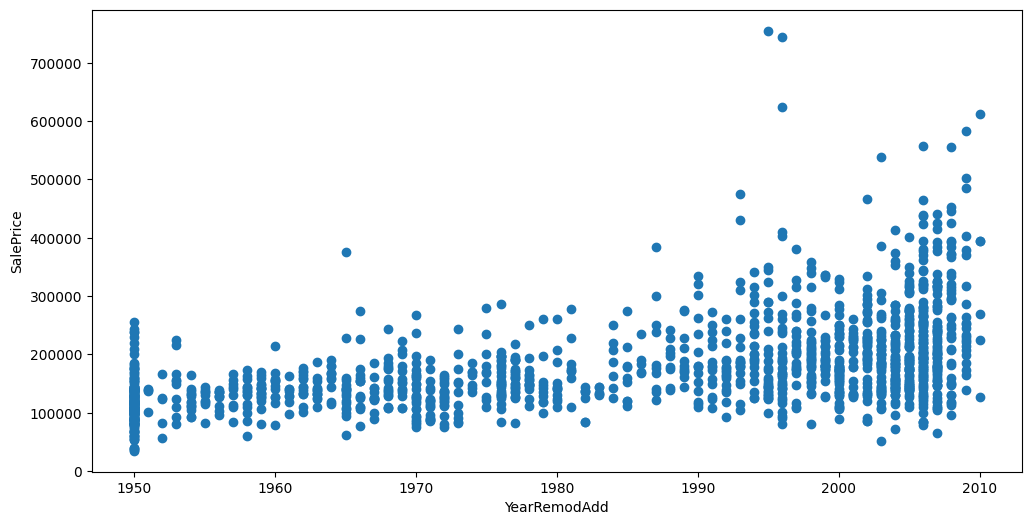

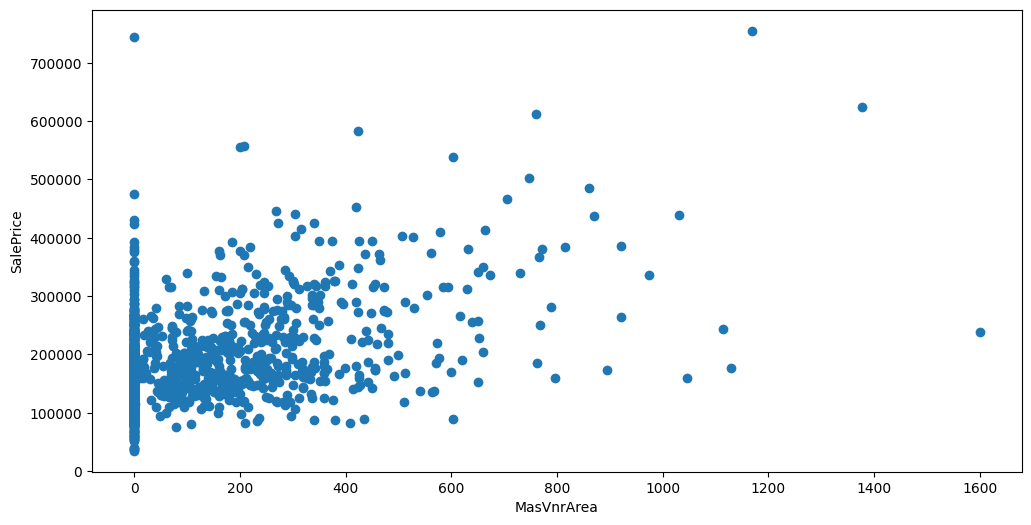

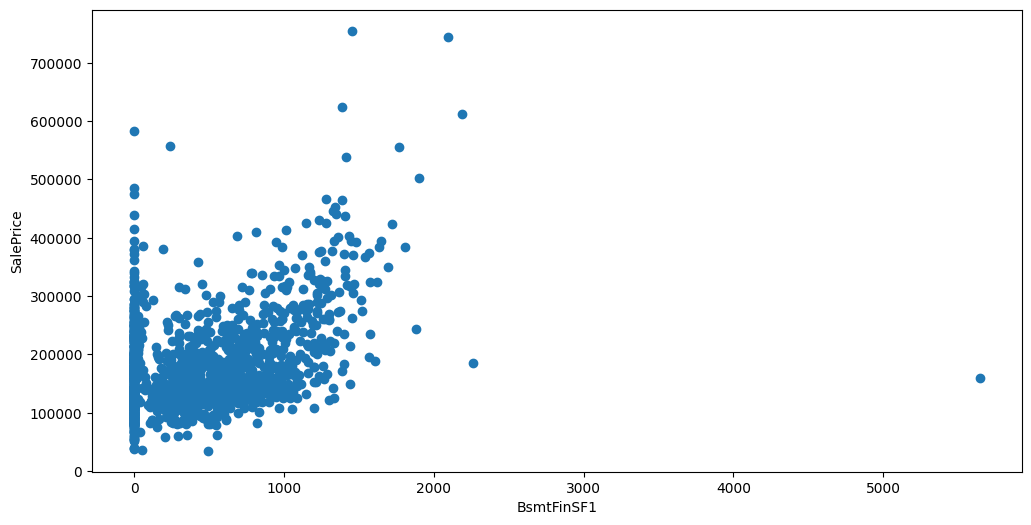

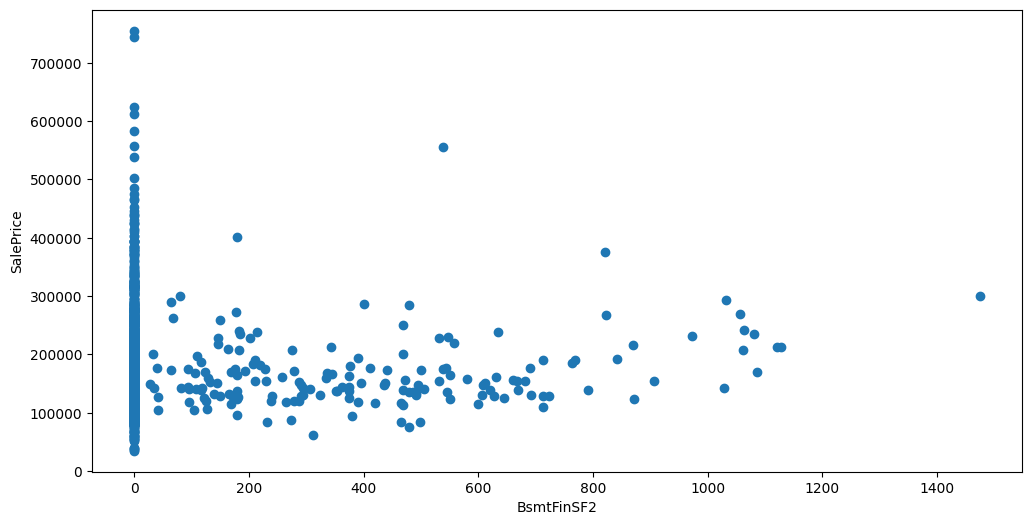

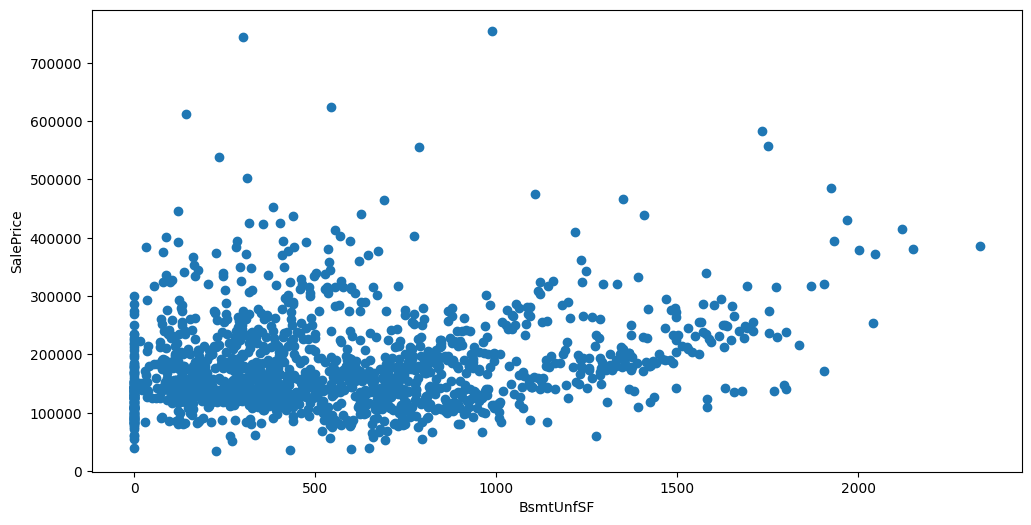

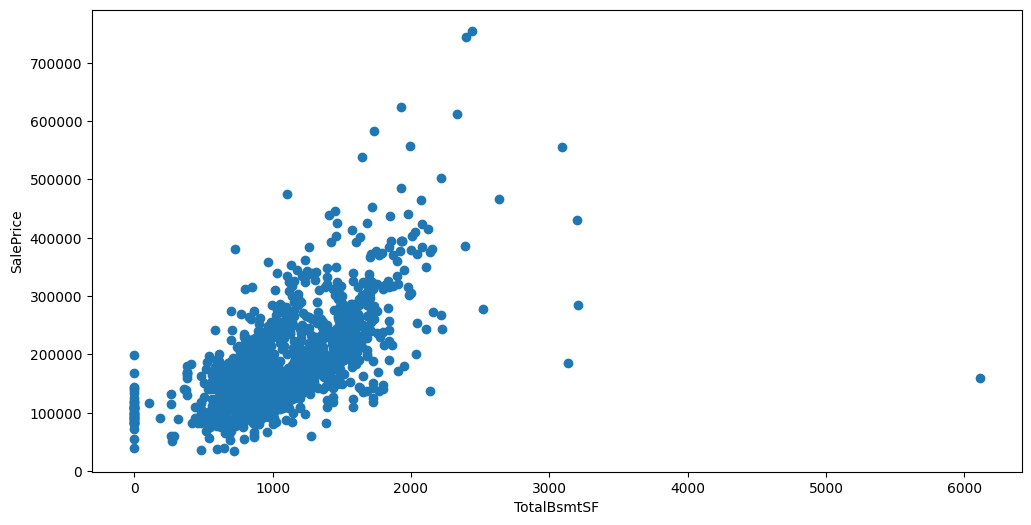

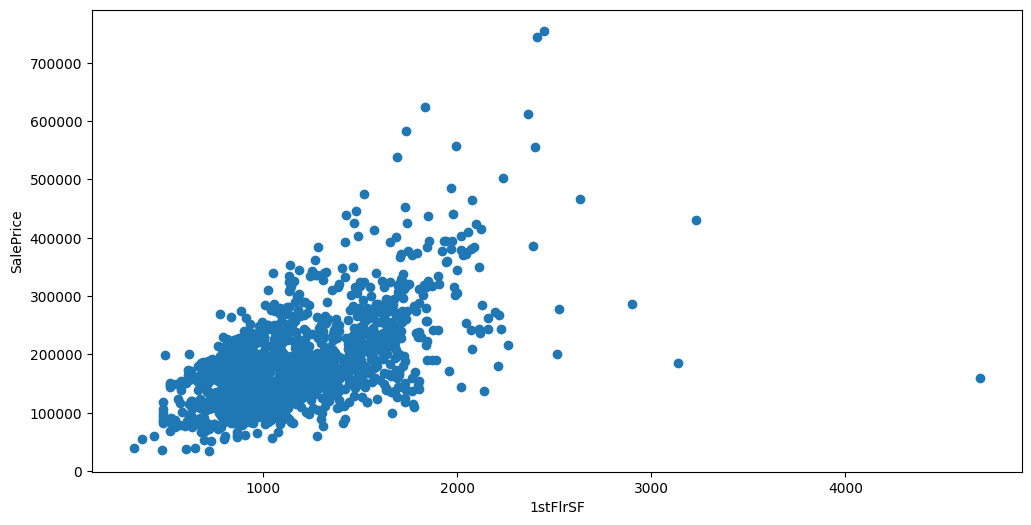

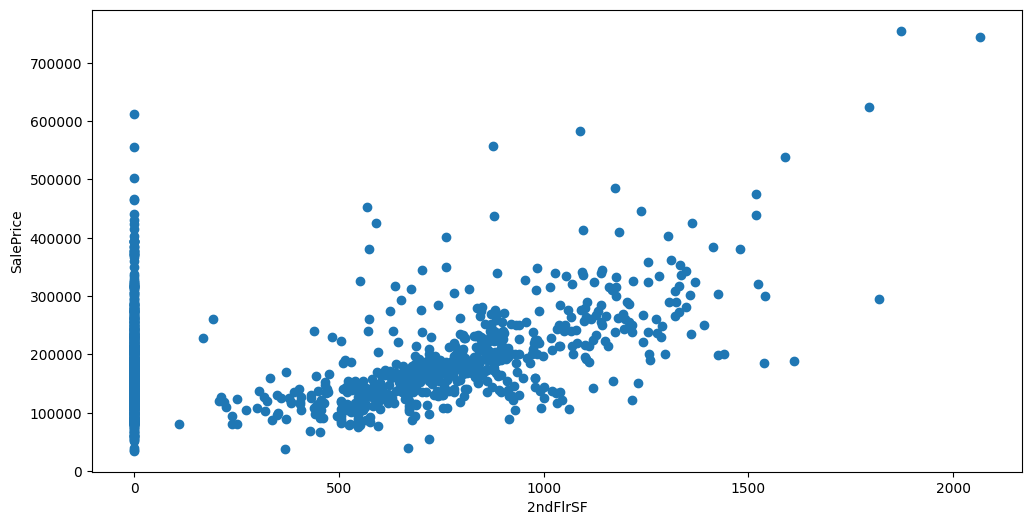

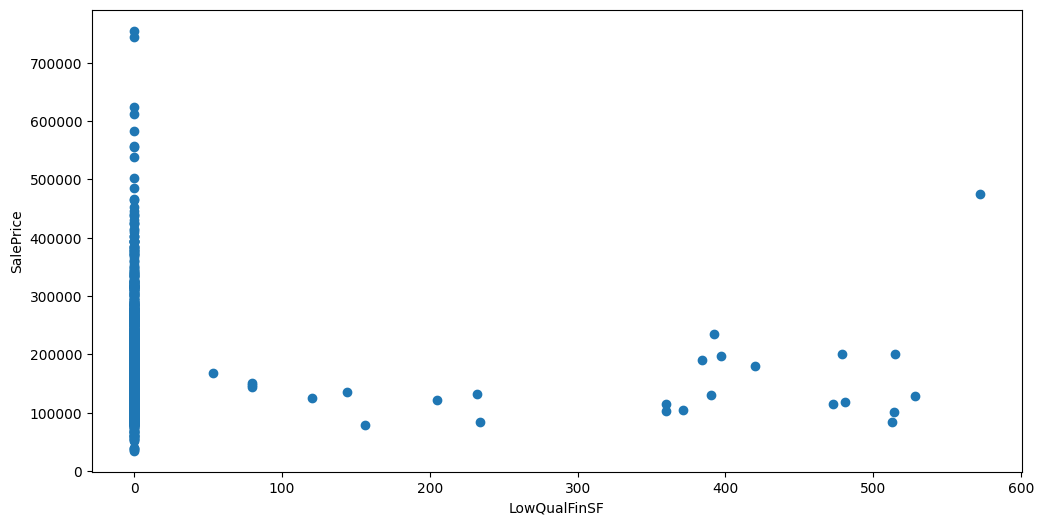

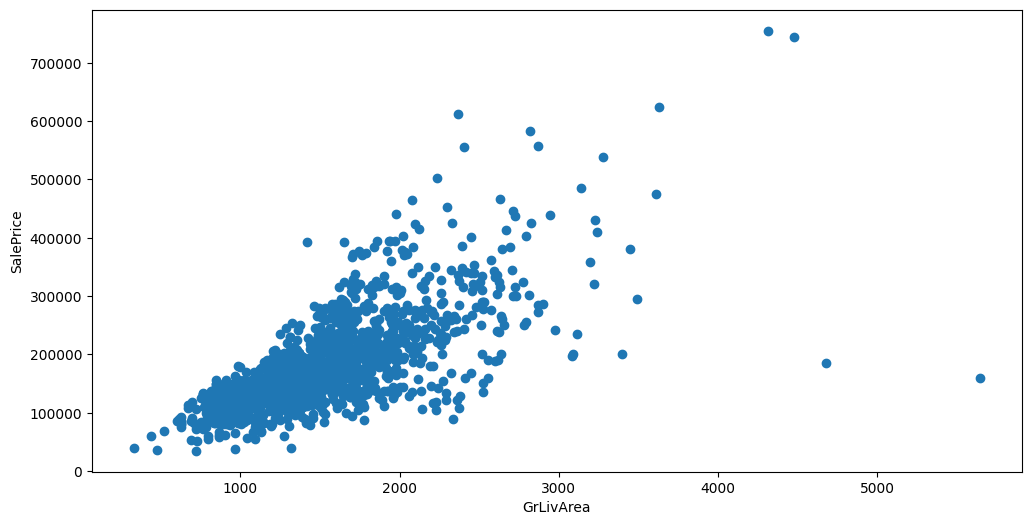

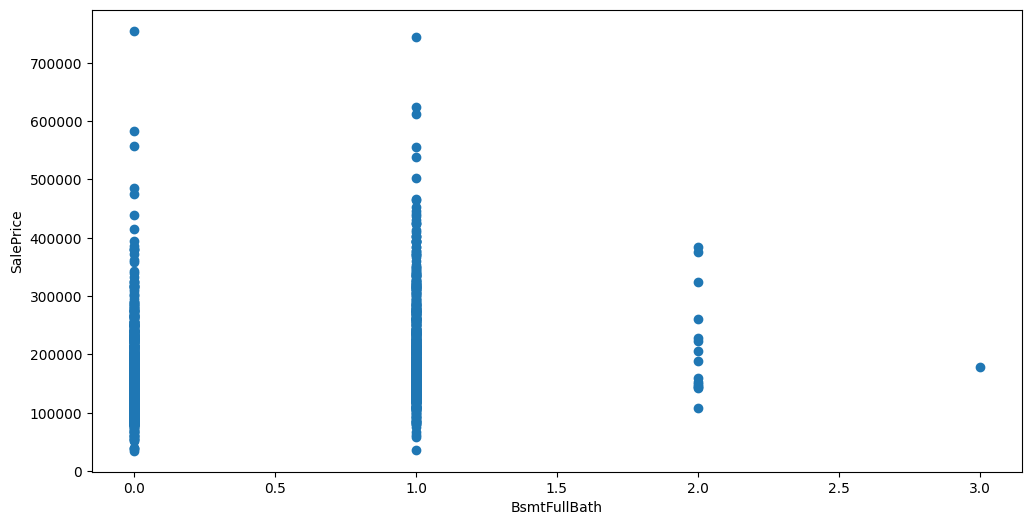

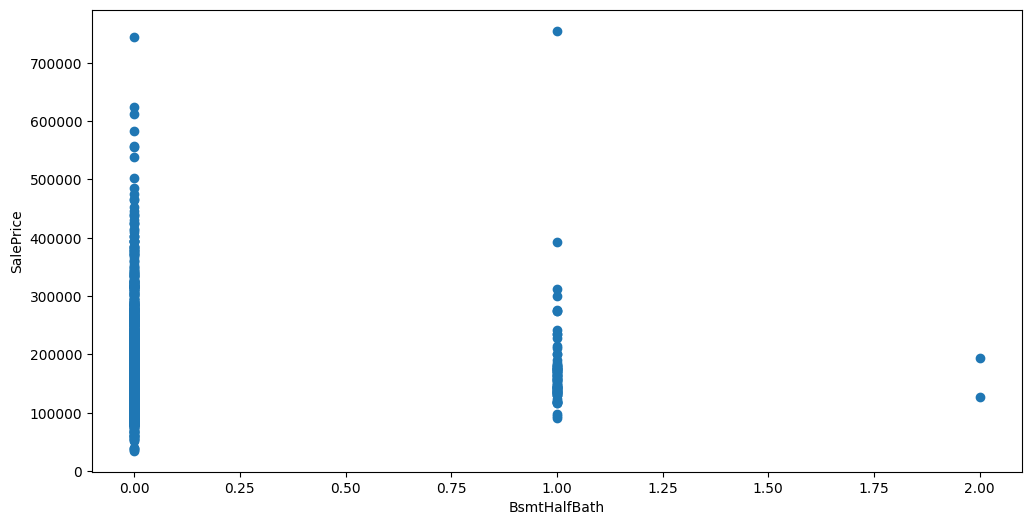

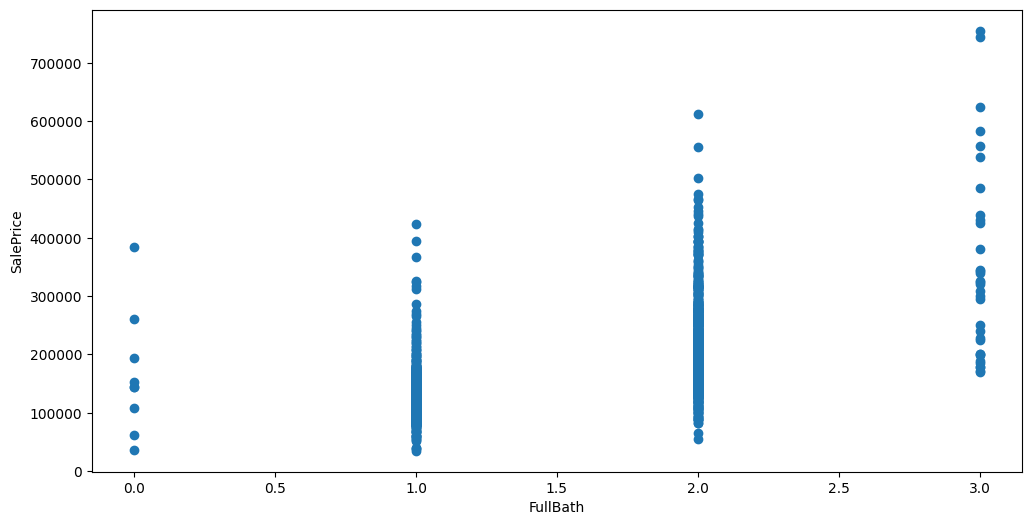

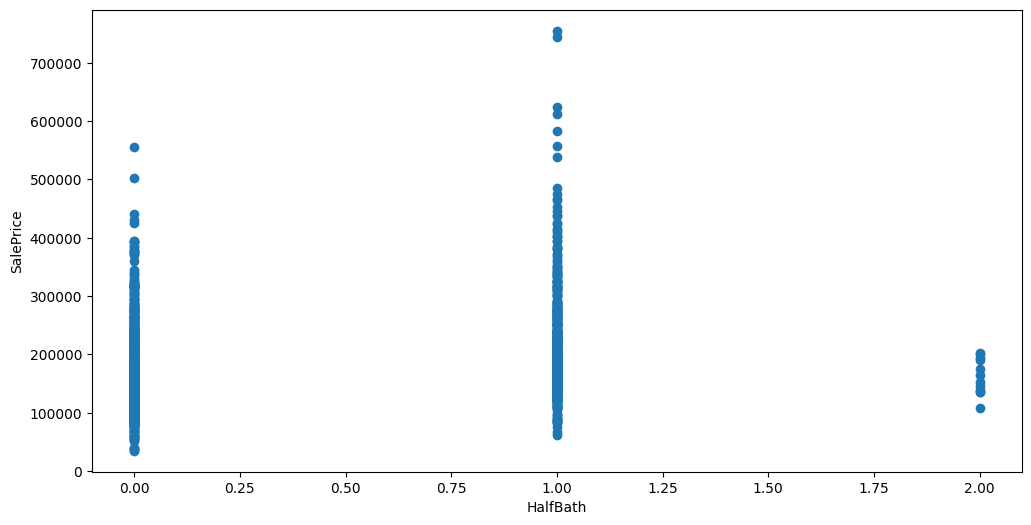

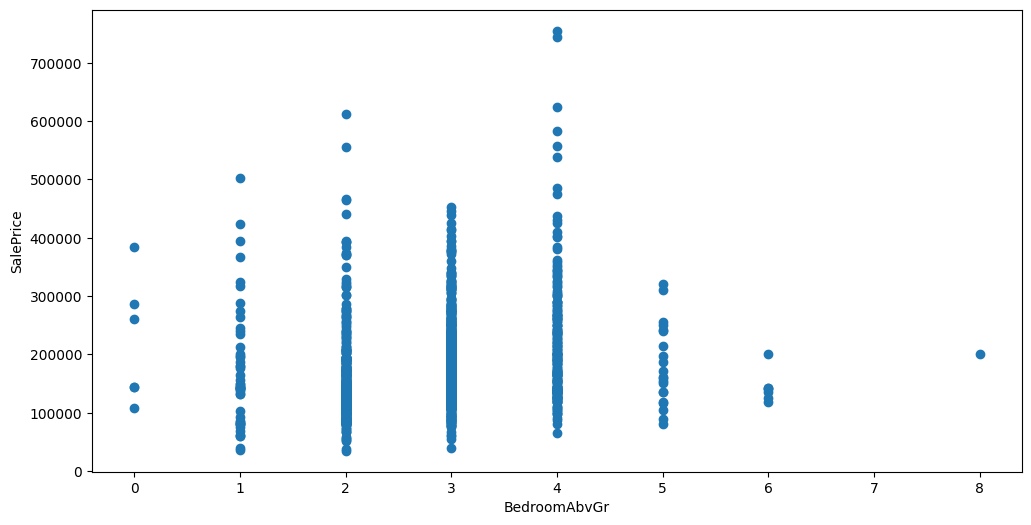

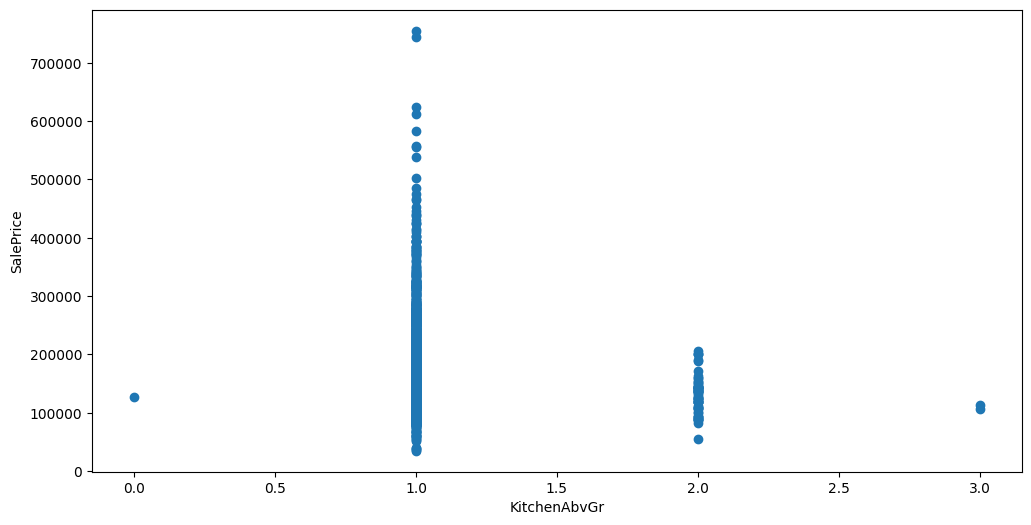

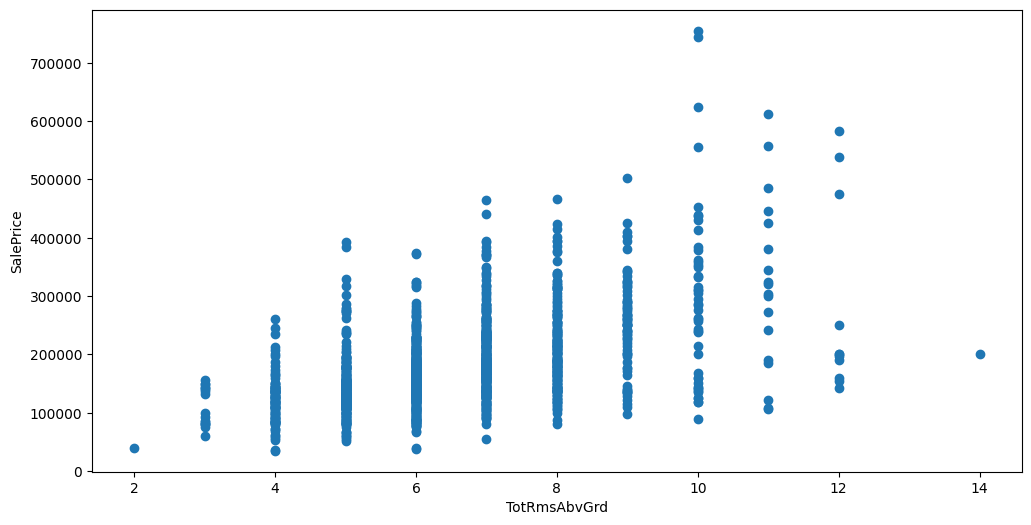

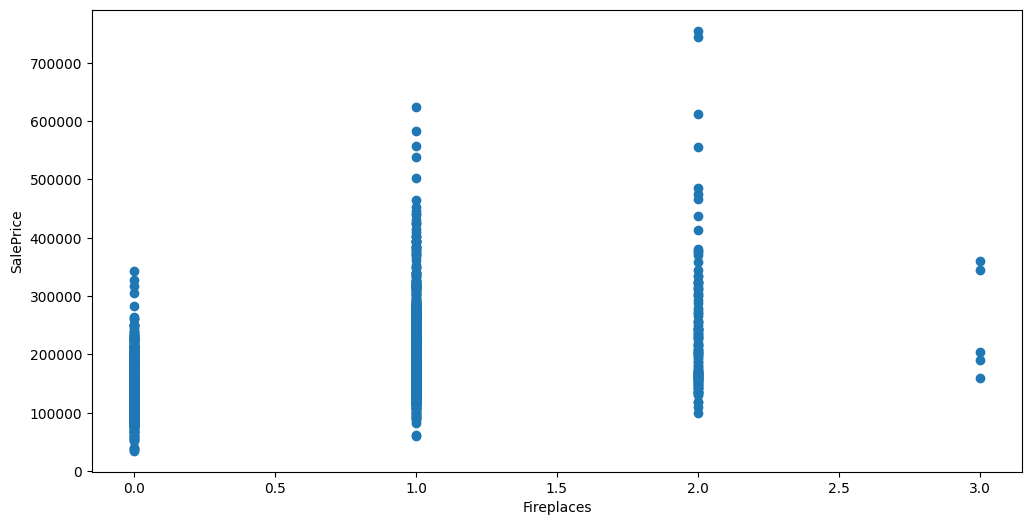

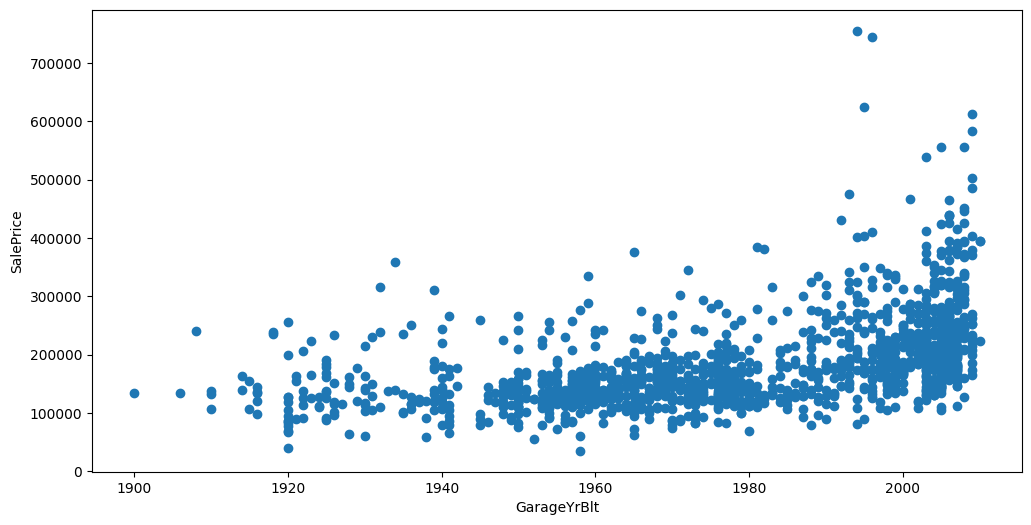

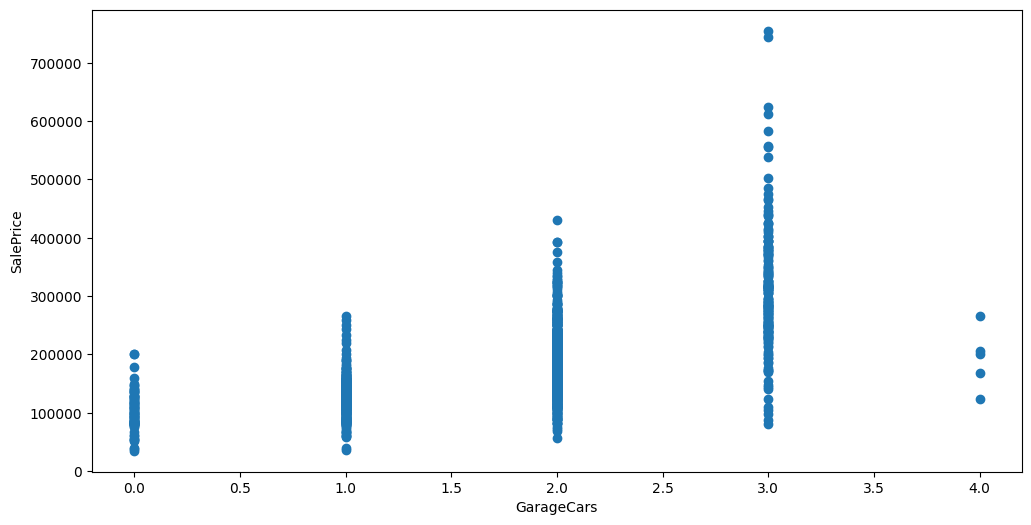

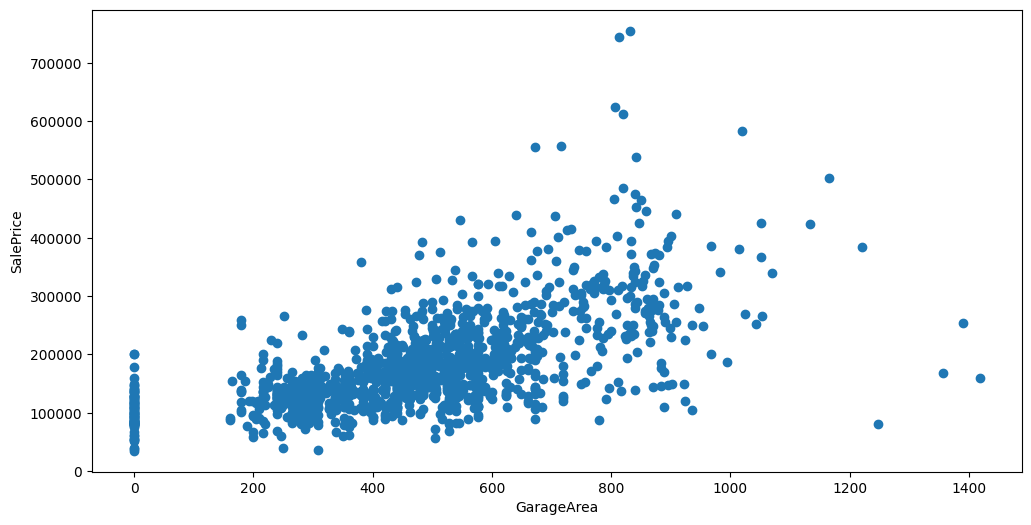

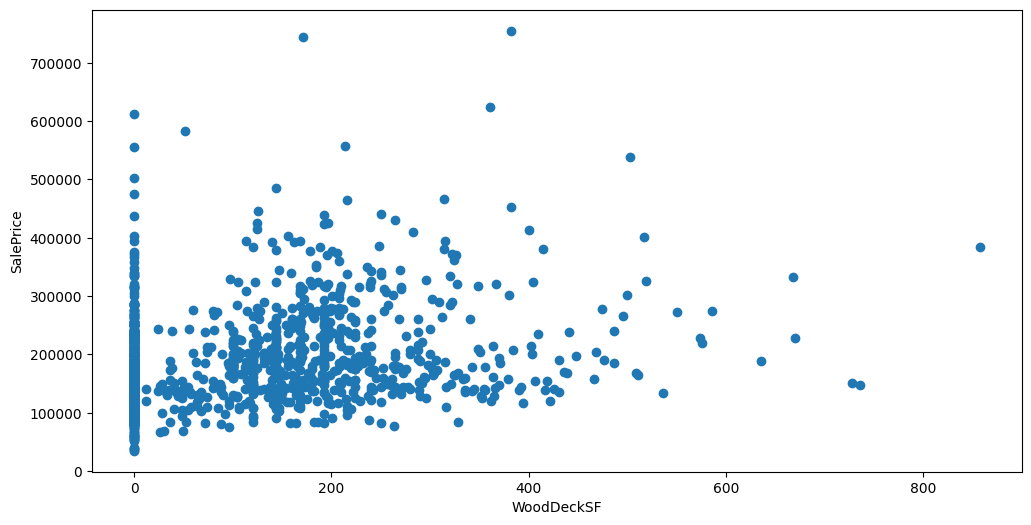

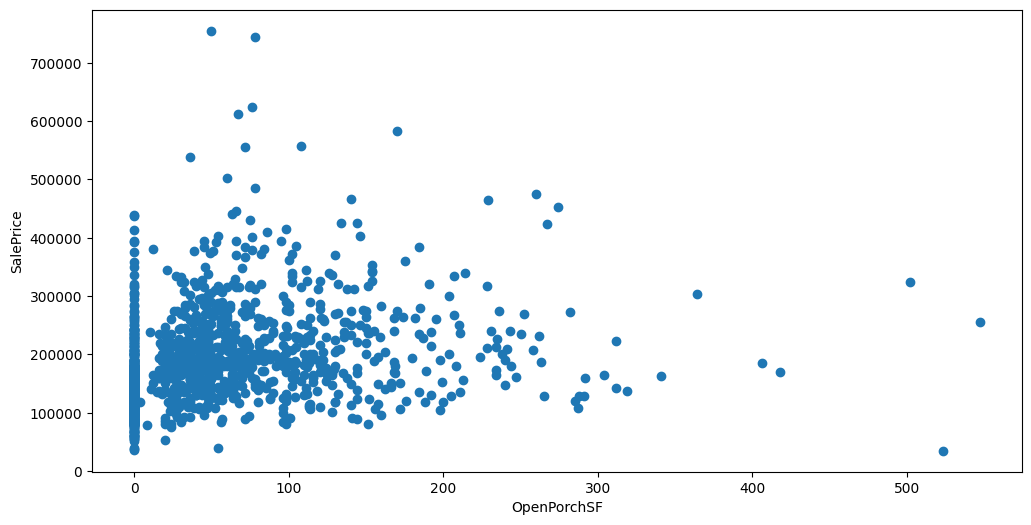

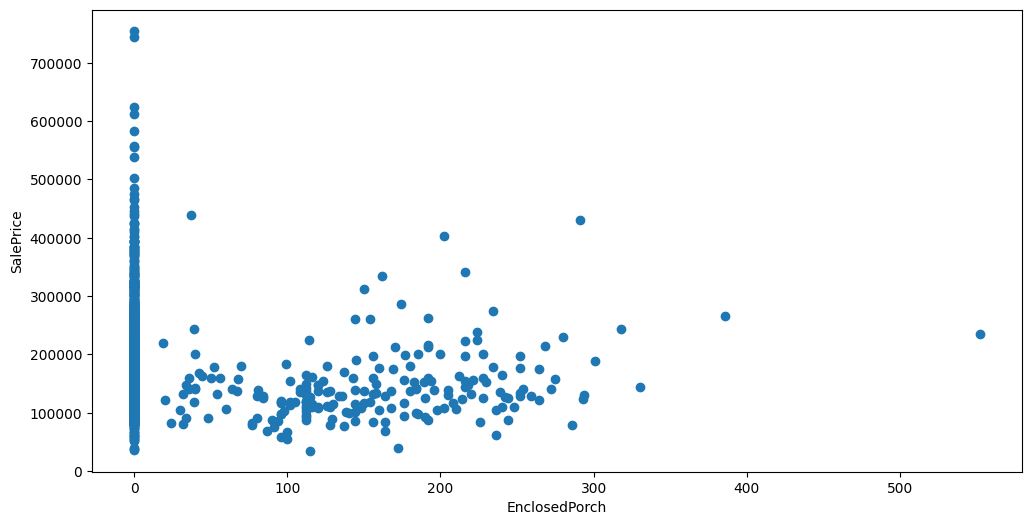

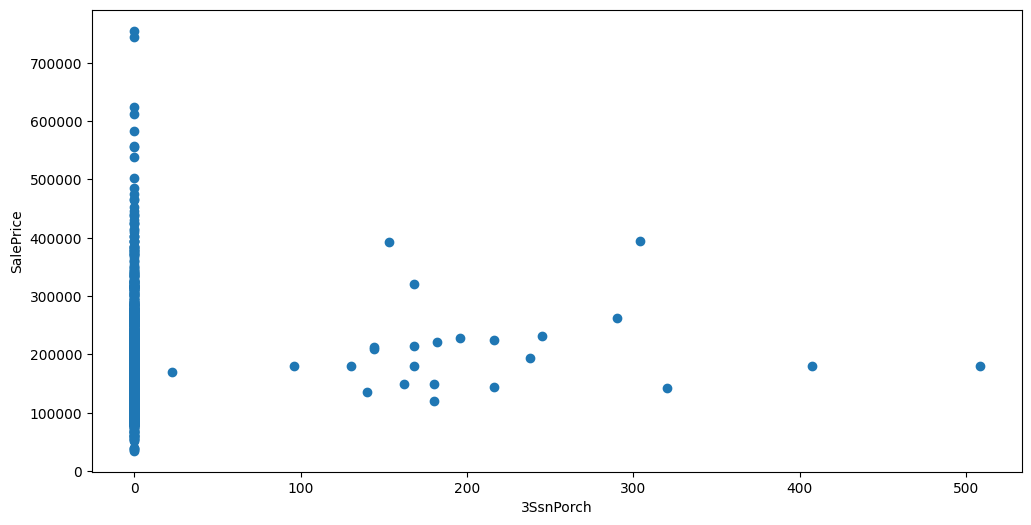

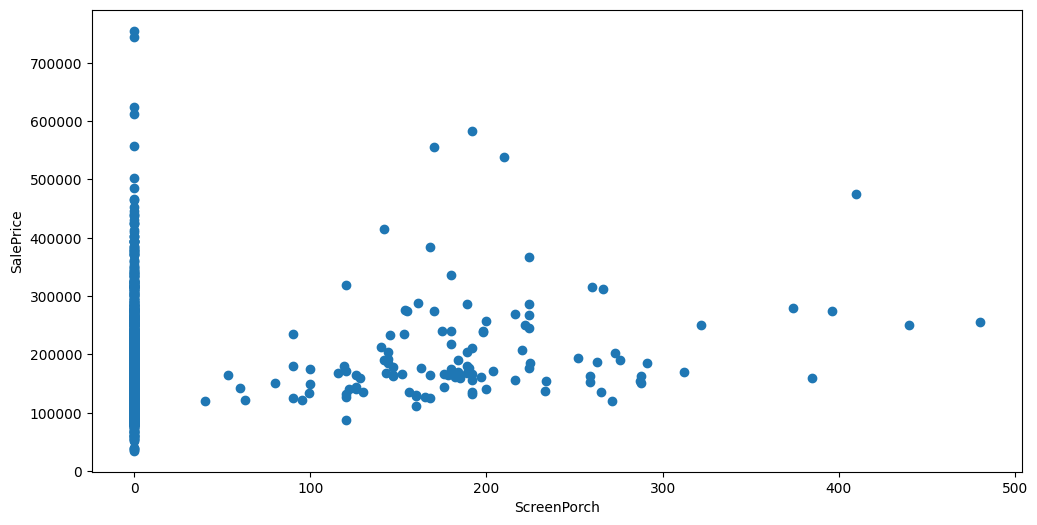

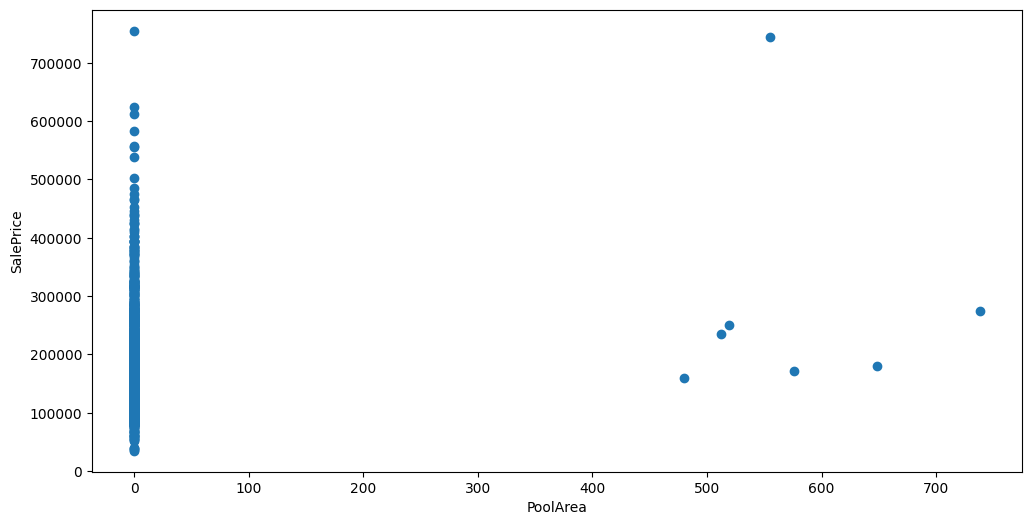

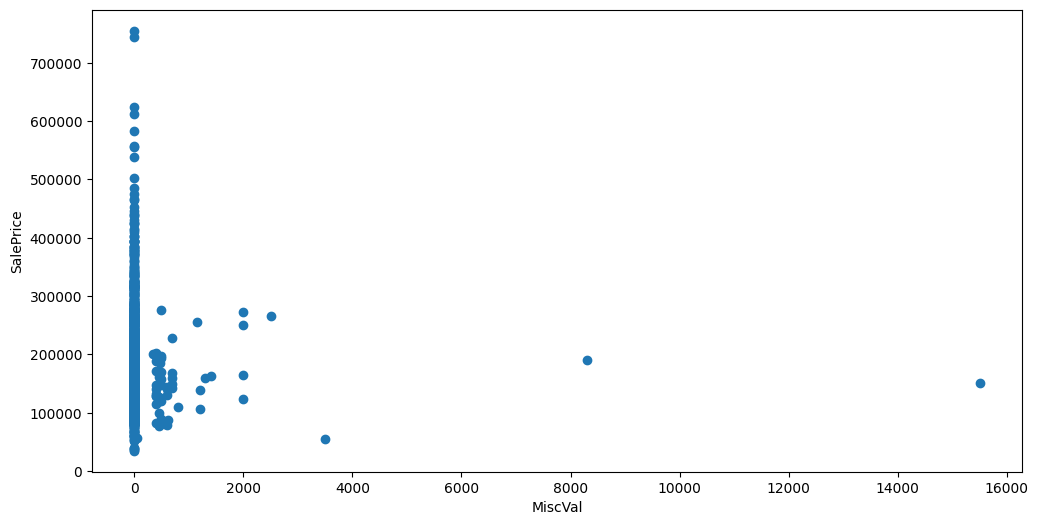

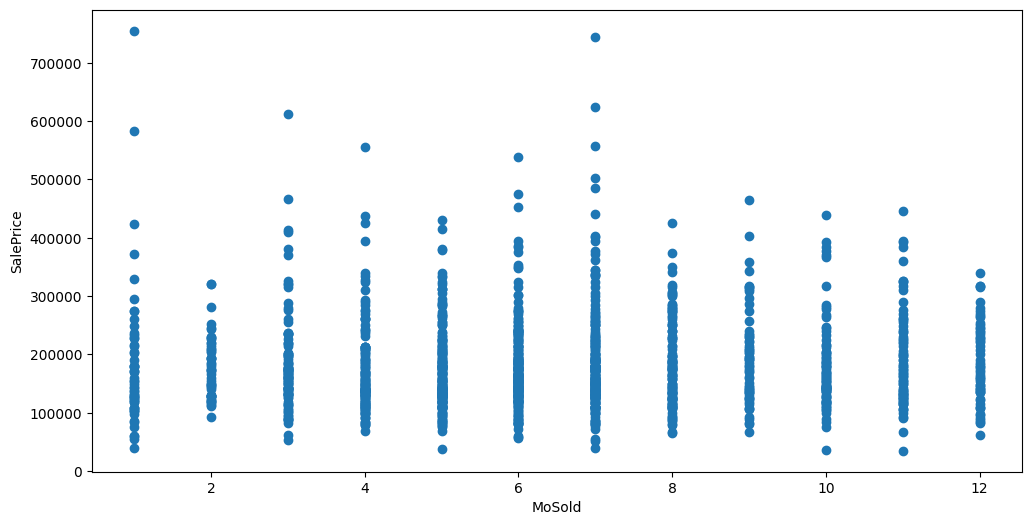

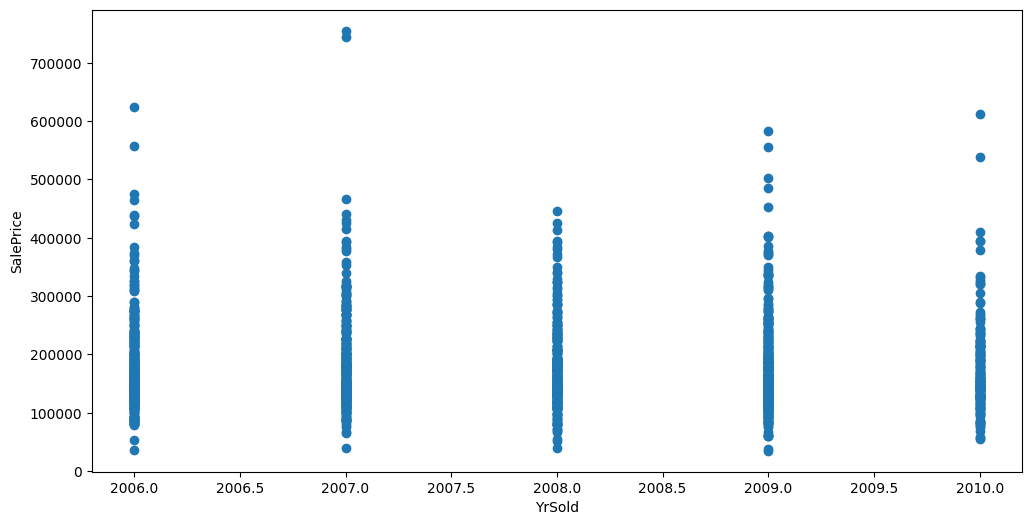

In [19]:
for feature_name in selector.numeric_features:
    plt.figure(figsize=(12,6))
    plt.scatter(feature_name, 'SalePrice', data=df)
    plt.xlabel(feature_name)
    plt.ylabel('SalePrice')
    plt.show()

In [20]:
data = df.copy()

Добавим признак TotalSF: общая площадь дома (с подвалом). TotalSF = GrLivArea + TotalBsmtSF

In [21]:
data['TotalSF'] = data['GrLivArea'] + data['TotalBsmtSF']

In [22]:
np.corrcoef(data['TotalSF'], data['SalePrice'])

array([[1.        , 0.77895883],
       [0.77895883, 1.        ]])

Получили коэффициент корреляции 0.78 нового признака с таргетом, что больше коэффициентов корреляции признаков GrLivArea и TotalBsmtSF с таргетом. Значит оставляем новый признак, а старые признаки удалим (т.к. они сильно коррелируют с новым признаком)

Нужно проверить 3 гипотезы:

0) метрика лучше без нового признака (нулевая гипотеза; RMSLE = 0.14054)
1) метрика лучше с новым (TotalSF) и старыми (GrLivArea и TotalBsmtSF) признаками вместе
2) метрика лучше с новым признаком, но без 2 старых

In [25]:
# Hypothesis 1
fitted_model_feat_eng = train_and_val_baseline(data, ['Id', 'Alley', 'PoolQC', 'MiscFeature'], 'SalePrice')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3455
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 177
[LightGBM] [Info] Start training from score 12.030658
baseline RMSE on train: 0.04233
baseline RMSE on val: 0.14058


D:\MyScripts\SDS\.venv\NASDAQ-risk-return-analisys\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
D:\MyScripts\SDS\.venv\NASDAQ-risk-return-analisys\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [35]:
# Hypothesis 2
fitted_model_feat_eng = train_and_val_baseline(data, ['Id', 'Alley', 'PoolQC', 'MiscFeature', 'GrLivArea', 'TotalBsmtSF'], 'SalePrice')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2945
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 175
[LightGBM] [Info] Start training from score 12.030658
baseline RMSE on train: 0.04240
baseline RMSE on val: 0.14141


D:\MyScripts\SDS\.venv\NASDAQ-risk-return-analisys\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
D:\MyScripts\SDS\.venv\NASDAQ-risk-return-analisys\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [29]:
submission = pd.read_csv("../data/raw/sample_submission.csv")
df_test = pd.read_csv("../data/raw/test.csv")

df_test['TotalSF'] = df_test['GrLivArea'] + df_test['TotalBsmtSF']
features_to_drop = ['Id', 'Alley', 'PoolQC', 'MiscFeature', 'GrLivArea', 'TotalBsmtSF']
X_test = df_test.drop(columns=features_to_drop)

y_pred_test = fitted_model_feat_eng.predict(X_test)
submission['SalePrice'] = y_pred_test
submission.to_csv("../data/output/my_submission.csv", index=False)

D:\MyScripts\SDS\.venv\NASDAQ-risk-return-analisys\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


В итоге оказалось справедливой гипотеза 0 (RMSLE on val dataset = 0.14054)